In [ ]:
# Import necessary libraries
from neo4j import GraphDatabase
import pandas as pd

# Define connection parameters
uri = "bolt://localhost:7687"  # Update if needed
user = "neo4j"
password = "password"

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

# Function to execute Cypher queries
def execute_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

# Close the driver connection
def close_driver():
    driver.close()


In [ ]:
# Query to count nodes
node_count_query = "MATCH (n) RETURN count(n) AS numNodes"
num_nodes = execute_query(node_count_query)
print(f"Number of Nodes: {num_nodes[0]['numNodes']}")

# Query to count edges
edge_count_query = "MATCH ()-[r]->() RETURN count(r) AS numEdges"
num_edges = execute_query(edge_count_query)
print(f"Number of Edges: {num_edges[0]['numEdges']}")


In [ ]:

# Community detection
### First RUN THIS IN NEO4J browser:CALL gds.graph.drop('myGraph')

###################

from neo4j import GraphDatabase
import pandas as pd
# Run this in broser CALL gds.graph.drop('myGraph')

# Define connection parameters
uri = "bolt://localhost:7687"  # Update if needed
user = "neo4j"
password = "12345678"

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters=parameters)
        return [record for record in result]

def close_driver():
    driver.close()

# Retrieve all node labels
node_labels_query = "CALL db.labels() YIELD label RETURN label"
node_labels = execute_query(node_labels_query)
node_labels_list = [record['label'] for record in node_labels]

# Retrieve all relationship types
relationship_types_query = "CALL db.relationshipTypes() YIELD relationshipType RETURN relationshipType"
relationship_types = execute_query(relationship_types_query)
relationship_types_list = [record['relationshipType'] for record in relationship_types]

# Convert lists to Cypher format
node_labels_str = ', '.join([f"'{label}'" for label in node_labels_list])
relationship_types_str = ', '.join([f"'{rtype}'" for rtype in relationship_types_list])

# Create a graph projection for GDS algorithms
create_graph_query = f"""
CALL gds.graph.project('myGraph', [{node_labels_str}], [{relationship_types_str}])
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
"""
projection_result = execute_query(create_graph_query)
print("Graph projection details:")
print(pd.DataFrame(projection_result))

# Run Louvain community detection
louvain_query = """
CALL gds.louvain.stream('myGraph')
YIELD nodeId, communityId
RETURN nodeId, communityId
"""
louvain_results = execute_query(louvain_query)
louvain_df = pd.DataFrame(louvain_results, columns=['nodeId', 'communityId'])



# Fetch node names or other properties
def get_node_properties(node_ids):
    node_properties_query = """
    UNWIND $nodeIds AS nodeId
    MATCH (n) WHERE id(n) = nodeId
    RETURN id(n) AS nodeId, n.name AS nodeName
    """
    return execute_query(node_properties_query, parameters={"nodeIds": node_ids})
column_names = ["nodeId", "nodeName"]
# Get node properties for the detected nodes
node_ids = louvain_df['nodeId'].unique()  # Get unique node IDs
node_properties = get_node_properties(node_ids)
node_properties_df = pd.DataFrame(node_properties, columns = column_names)

# print("\nNode properties:")
# print(node_properties_df.head(10))  # Print first 10 rows
# print("Columns in node properties:", node_properties_df.columns)
# print("Node properties DataFrame info:")
# node_properties_df.info()

print(node_properties_df)
# Ensure nodeId is of the same type in both DataFrames
louvain_df['nodeId'] = louvain_df['nodeId'].astype(str)
node_properties_df['nodeId'] = node_properties_df['nodeId'].astype(str)

# Perform the merge with error handling
try:
    full_df = louvain_df.merge(node_properties_df, on='nodeId', how='left')
    print("Merge successful. Full DataFrame:")
    print(full_df.head(10))
    print(full_df.info())
except KeyError as e:
    print(f"KeyError encountered: {e}")
    print("louvain_df columns:", louvain_df.columns)
    print("node_properties_df columns:", node_properties_df.columns)
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Node label frequency (no source given)
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Define connection parameters
uri = "bolt://localhost:7687"  # Update if needed
user = "neo4j"
password = "12345678"  # Update with your password

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters=parameters)
        return [record for record in result]

def get_all_labels():
    query = "CALL db.labels() YIELD label RETURN label"
    return execute_query(query)

def count_nodes_by_label(label):
    query = f"MATCH (n:{label}) RETURN COUNT(n) AS frequency"
    result = execute_query(query)
    return result[0]['frequency'] if result else 0

# Retrieve all labels
labels = get_all_labels()
label_names = [record['label'] for record in labels]

# Count nodes for each label
label_counts = {label: count_nodes_by_label(label) for label in label_names}

# Convert to DataFrame and sort by frequency in descending order
df = pd.DataFrame(list(label_counts.items()), columns=['NodeType', 'Frequency'])
df = df.sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df['NodeType'], df['Frequency'], color='skyblue')
plt.xlabel('Node Type')
plt.ylabel('Frequency')
plt.title('Node Types and Their Frequencies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Close the driver
driver.close()


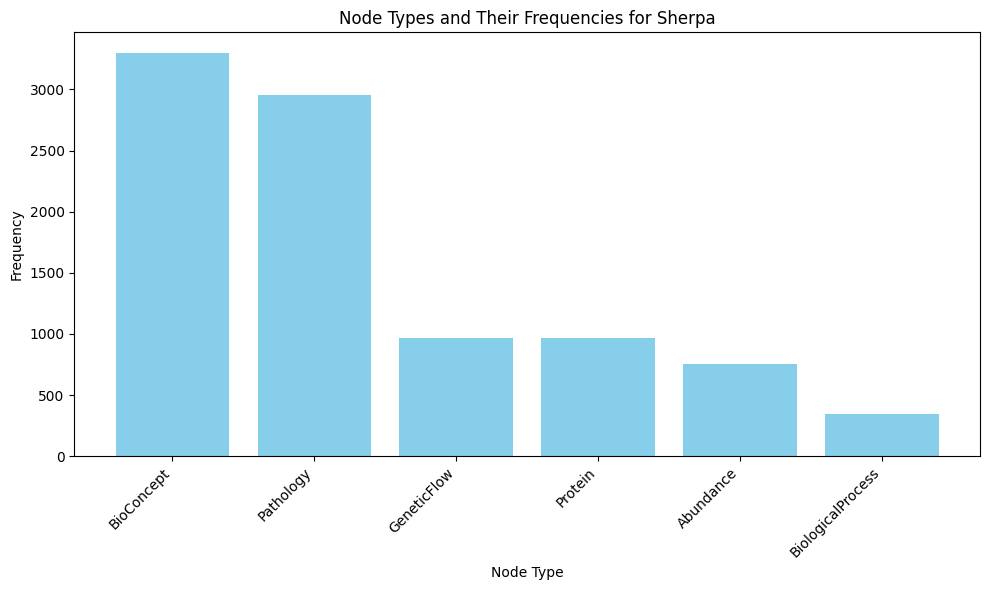

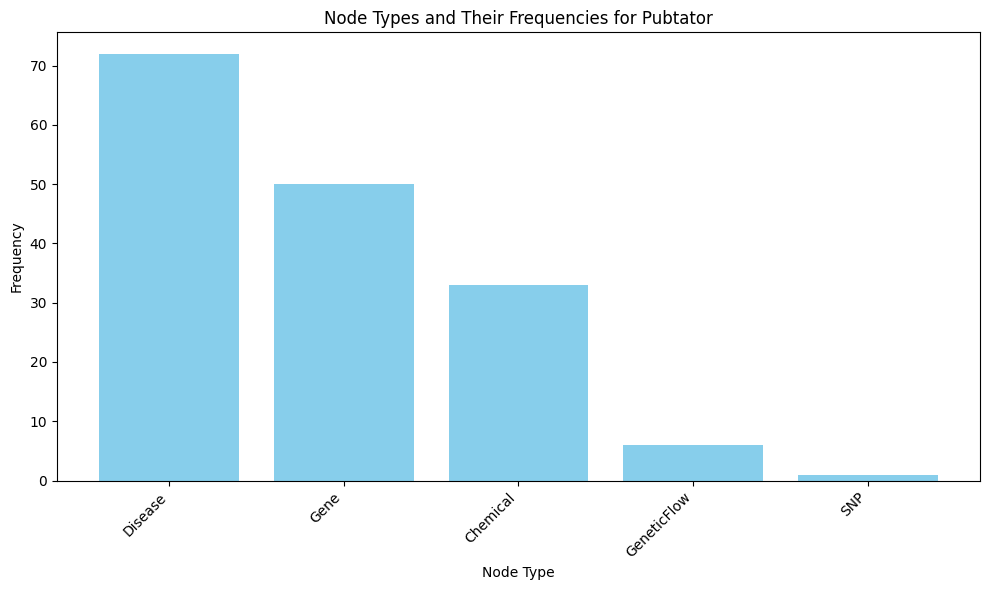

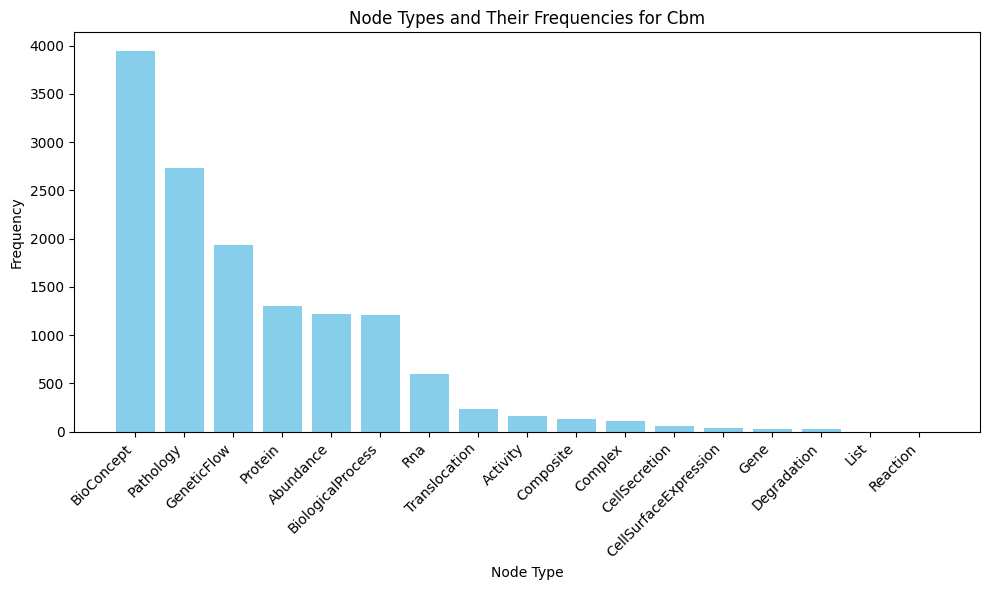

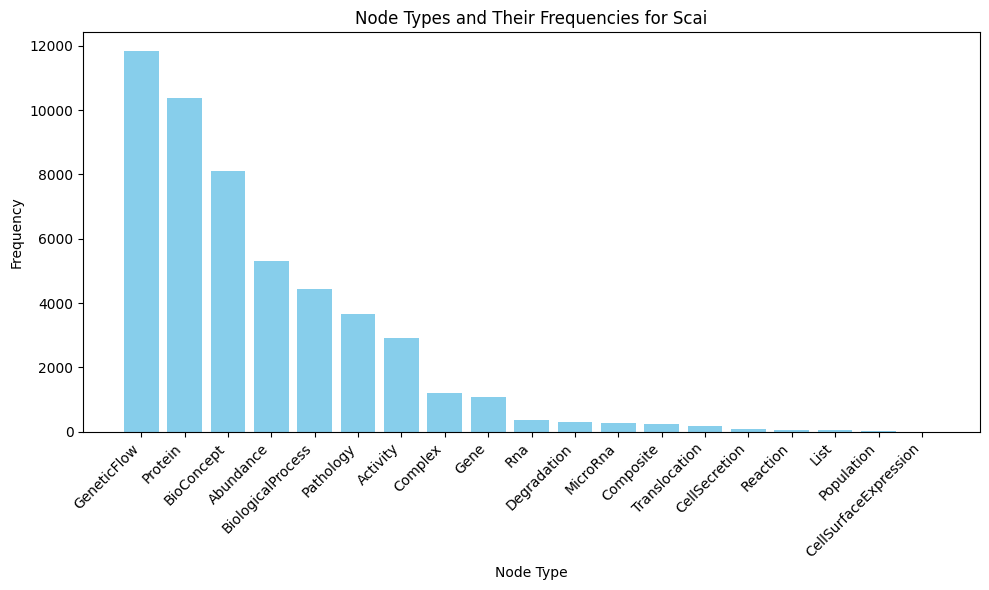

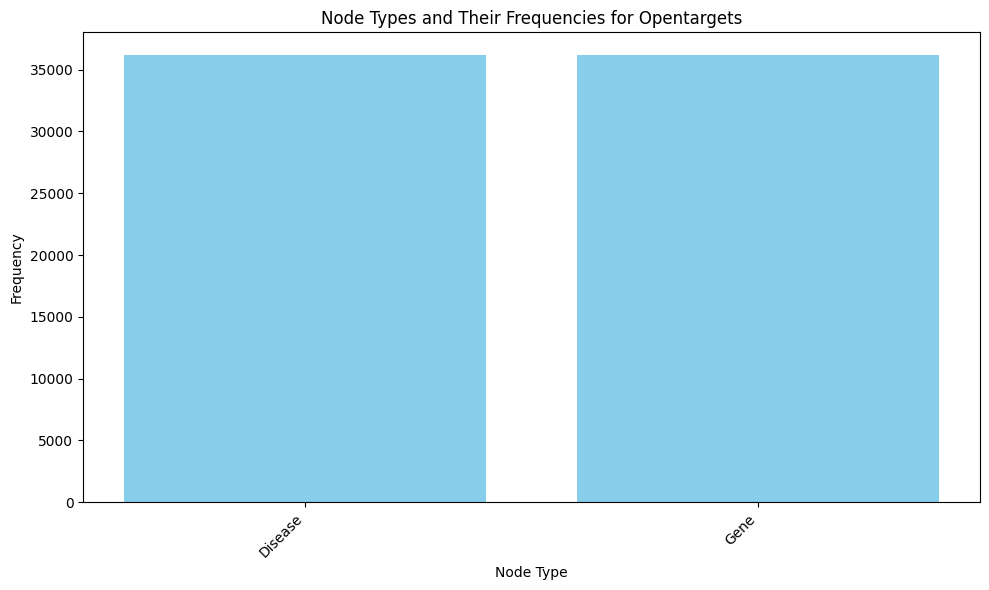

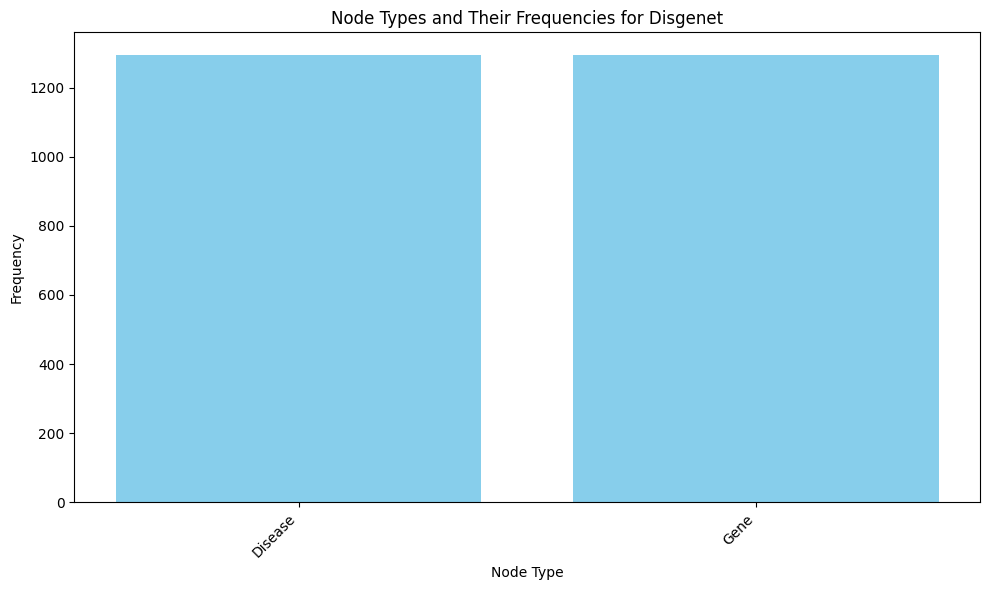

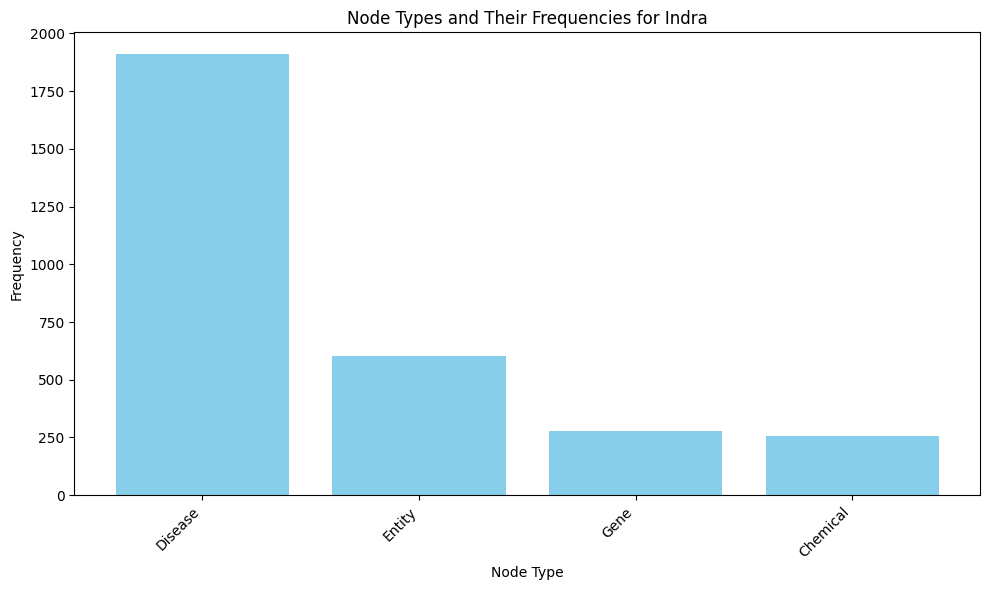

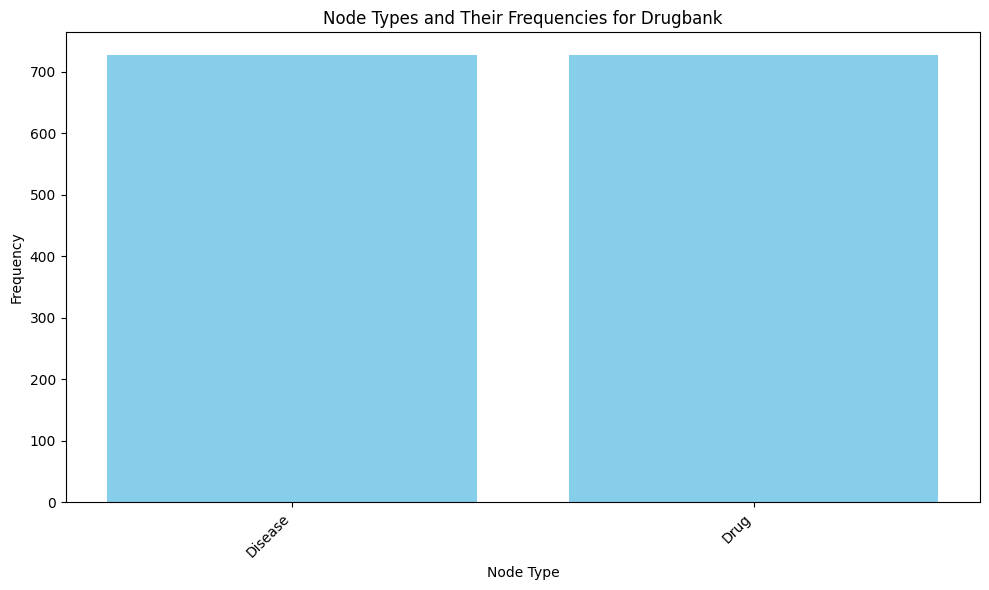

In [2]:
# Node label frequency for different sources
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Define connection parameters
uri = "bolt://localhost:7687"  # Update if needed
user = "neo4j"
password = "12345678"  # Update with your password

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters=parameters)
        return [record for record in result]

def get_all_labels():
    query = "CALL db.labels() YIELD label RETURN label"
    return execute_query(query)

def count_nodes_by_label_and_source(label, source):
    query = f"""
    MATCH (n:{label})-[r]-()
    WHERE toLower(r.source) contains toLower($source)
    RETURN COUNT(n) AS frequency
    """
    result = execute_query(query, {"source": source})
    return result[0]['frequency'] if result else 0

# List of sources to search for
sources = ['sherpa', 'pubtator', 'cbm', 'scai', 'opentargets', 'disgenet', 'indra', 'drugbank']

# Retrieve all labels
labels = get_all_labels()
label_names = [record['label'] for record in labels]

# Loop through each source, calculate frequencies, and plot bar charts
for source in sources:
    # Count nodes for each label filtered by source
    label_counts = {label: count_nodes_by_label_and_source(label, source) for label in label_names}
    
    # Convert to DataFrame and sort by frequency in descending order
    df = pd.DataFrame(list(label_counts.items()), columns=['NodeType', 'Frequency'])
    df = df[df['Frequency'] > 0]  # Filter out labels with zero frequency
    df = df.sort_values(by='Frequency', ascending=False)
    
    if not df.empty:
        # Plotting for the current source
        plt.figure(figsize=(10, 6))
        plt.bar(df['NodeType'], df['Frequency'], color='skyblue')
        plt.xlabel('Node Type')
        plt.ylabel('Frequency')
        plt.title(f'Node Types and Their Frequencies for {source.capitalize()}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Show the plot
        plt.show()

# Close the driver
driver.close()


In [ ]:
# Relationship label frequency (no source given)
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Define connection parameters
uri = "bolt://localhost:7687"  # Update if needed
user = "neo4j"
password = "12345678"  # Update with your password

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters=parameters)
        return [record for record in result]

def get_all_relationship_types():
    query = "CALL db.relationshipTypes() YIELD relationshipType RETURN relationshipType"
    return execute_query(query)

def count_relationships_by_type(relationship_type):
    query = f"MATCH ()-[r:{relationship_type}]->() RETURN COUNT(r) AS frequency"
    result = execute_query(query)
    return result[0]['frequency'] if result else 0

# Retrieve all relationship types
relationship_types = get_all_relationship_types()
relationship_type_names = [record['relationshipType'] for record in relationship_types]

# Count relationships for each type
relationship_counts = {rtype: count_relationships_by_type(rtype) for rtype in relationship_type_names}

# Convert to DataFrame and sort by frequency in descending order
df = pd.DataFrame(list(relationship_counts.items()), columns=['RelationshipType', 'Frequency'])
df = df.sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df['RelationshipType'], df['Frequency'], color='lightgreen')
plt.xlabel('Relationship Type')
plt.ylabel('Frequency')
plt.title('Relationship Types and Their Frequencies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Close the driver
driver.close()


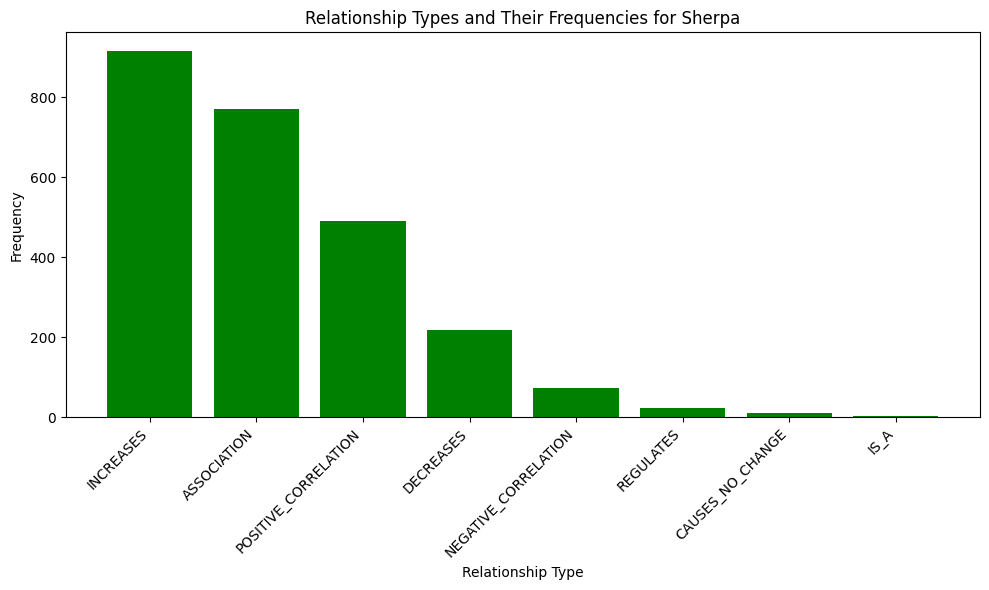

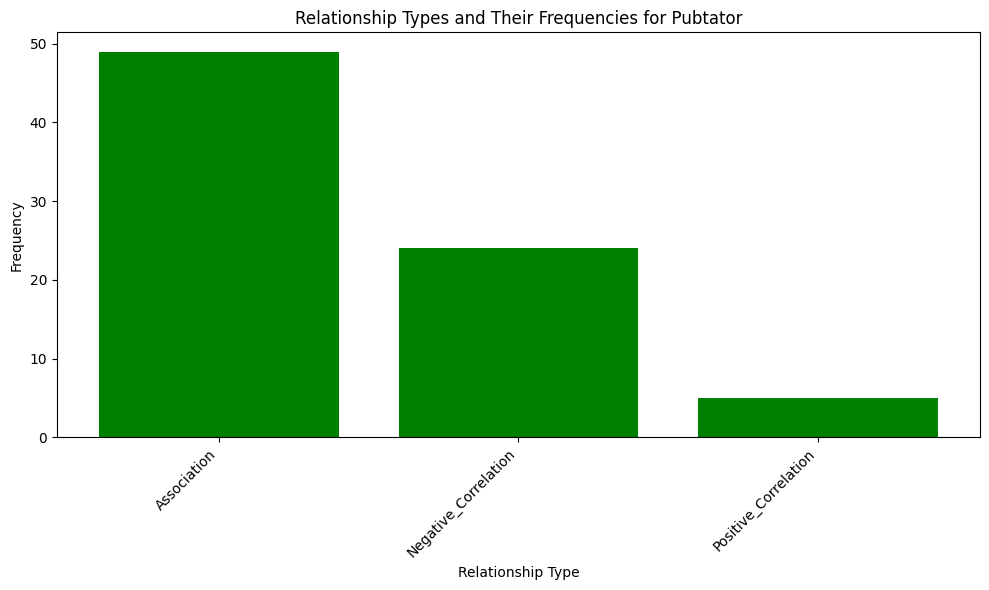

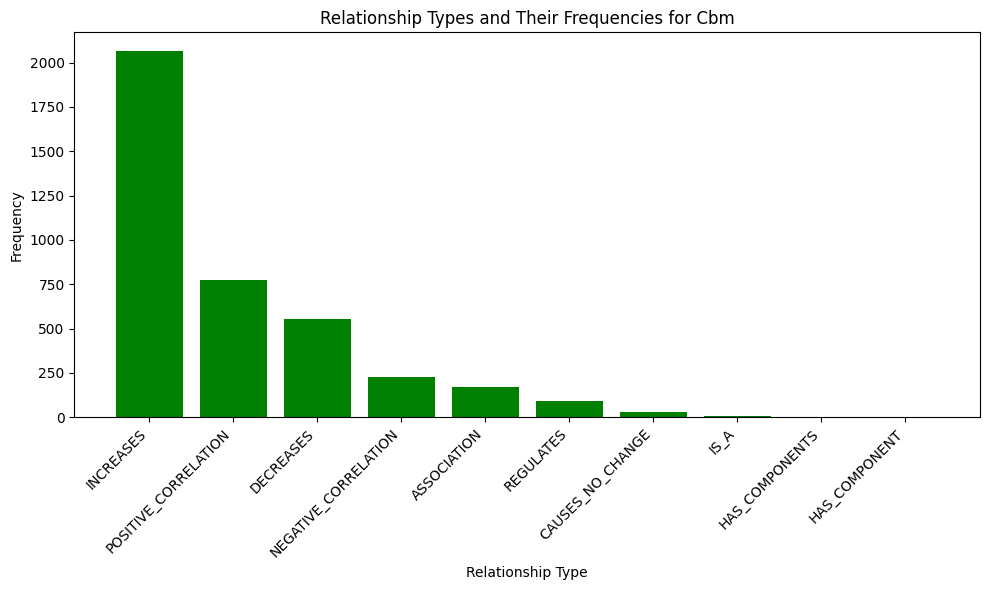

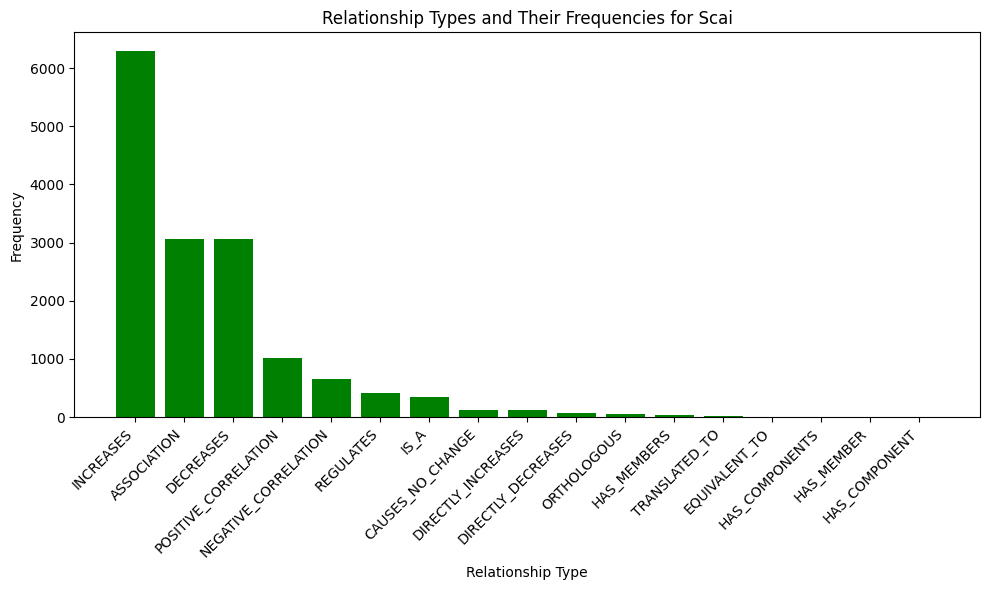

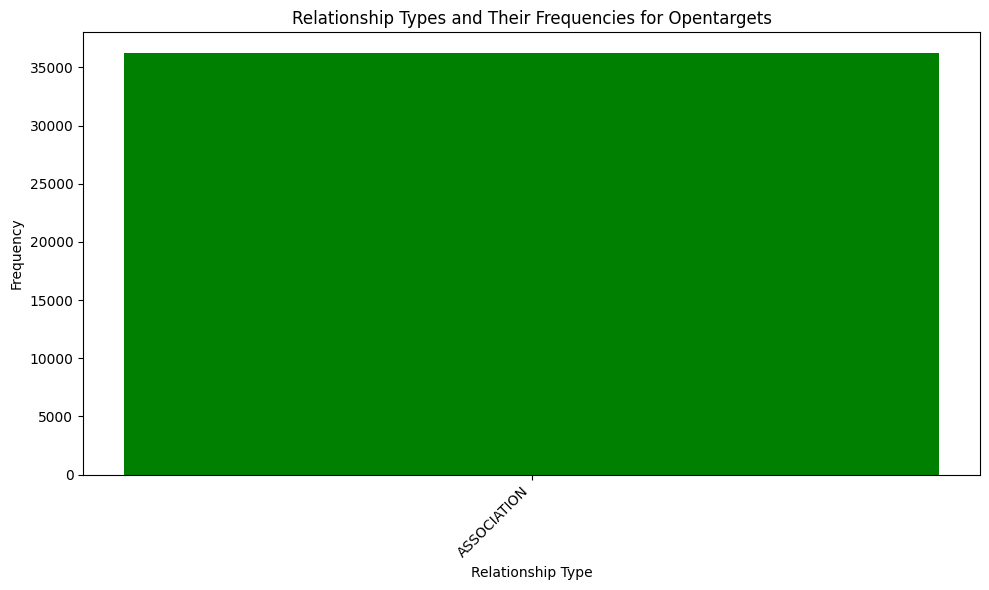

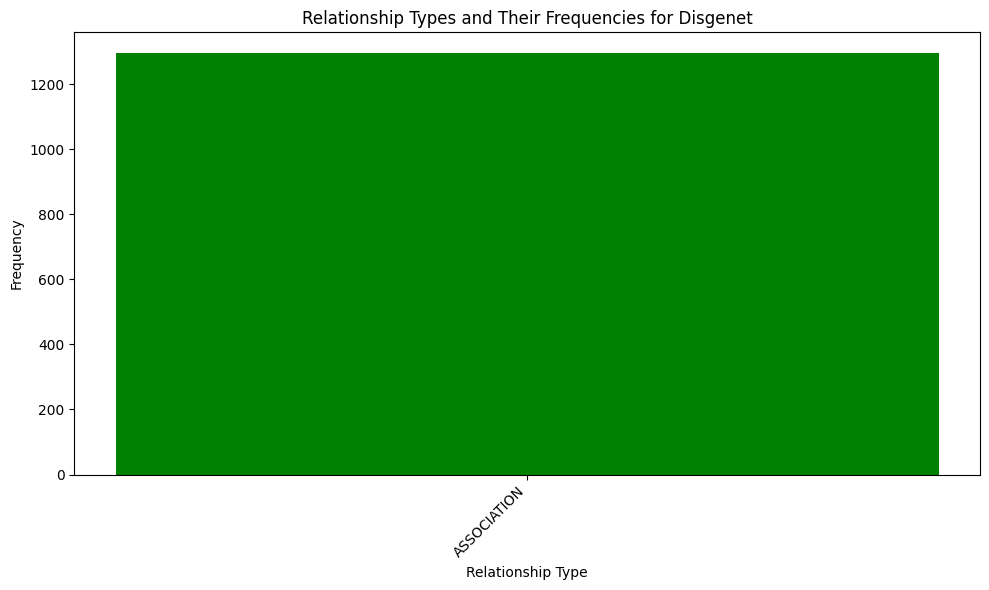

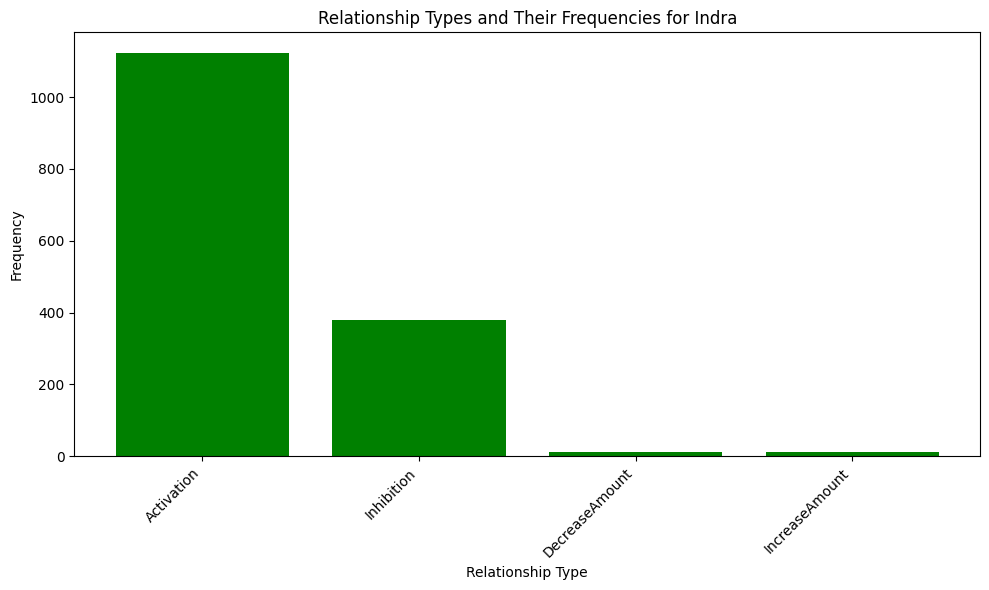

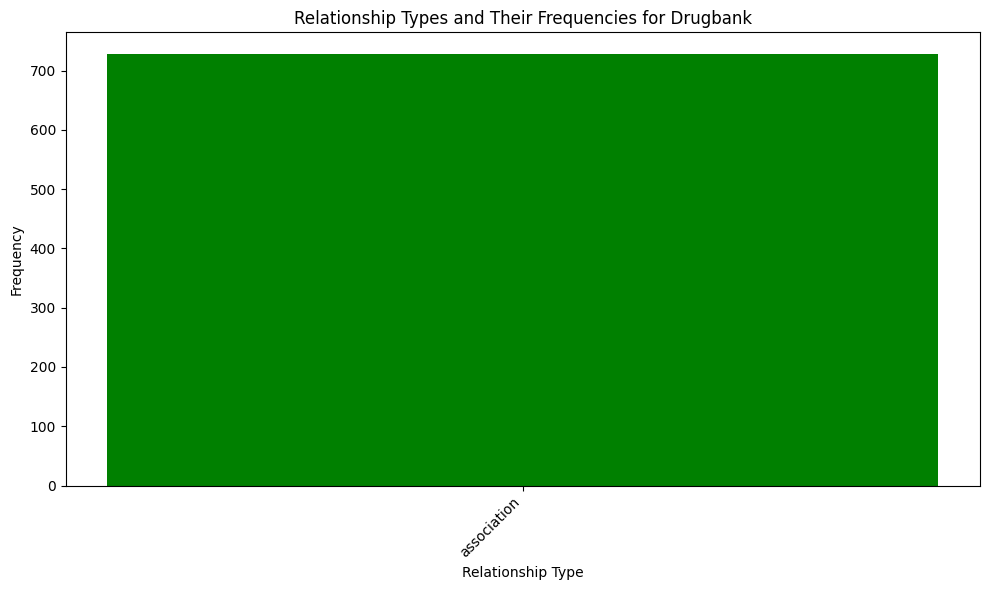

In [3]:

# Relationship label frequency by source
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Define connection parameters
uri = "bolt://localhost:7687"  # Update if needed
user = "neo4j"
password = "12345678"  # Update with your password

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters=parameters)
        return [record for record in result]

def get_all_relationship_types():
    query = "CALL db.relationshipTypes() YIELD relationshipType RETURN relationshipType"
    return execute_query(query)

def count_relationships_by_type_and_source(relationship_type, source):
    query = f"""
    MATCH ()-[r:{relationship_type}]->()
    WHERE toLower(r.source) contains toLower($source)
    RETURN COUNT(r) AS frequency
    """
    result = execute_query(query, {"source": source})
    return result[0]['frequency'] if result else 0

# List of sources to search for
sources = ['sherpa', 'pubtator', 'cbm', 'scai', 'opentargets', 'disgenet', 'indra', 'drugbank']

# Retrieve all relationship types
relationship_types = get_all_relationship_types()
relationship_type_names = [record['relationshipType'] for record in relationship_types]

# Loop through each source, calculate frequencies, and plot bar charts
for source in sources:
    # Count relationships for each type filtered by source
    relationship_counts = {rtype: count_relationships_by_type_and_source(rtype, source) for rtype in relationship_type_names}
    
    # Convert to DataFrame and sort by frequency in descending order
    df = pd.DataFrame(list(relationship_counts.items()), columns=['RelationshipType', 'Frequency'])
    df = df[df['Frequency'] > 0]  # Filter out relationship types with zero frequency
    df = df.sort_values(by='Frequency', ascending=False)
    
    if not df.empty:
        # Plotting for the current source
        plt.figure(figsize=(10, 6))
        plt.bar(df['RelationshipType'], df['Frequency'], color='green')
        plt.xlabel('Relationship Type')
        plt.ylabel('Frequency')
        plt.title(f'Relationship Types and Their Frequencies for {source.capitalize()}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Show the plot
        plt.show()

# Close the driver
driver.close()


In [ ]:
# Centrality measure (various types) and bar charts (no data source given)
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Define connection parameters
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

def execute_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

def compute_centrality(graph_name, centrality_type):
    query = f"""
    CALL gds.{centrality_type}.stream('{graph_name}')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS nodeName, score AS centrality
    ORDER BY centrality DESC;
    """
    return execute_query(query)

# Define centrality types
centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']

# Compute and store centrality measures
results = {}
for centrality_type in centrality_types:
    data = compute_centrality('myGraph', centrality_type)
    df = pd.DataFrame(data)
    
    # Print the columns to check their names
    print(f"Original columns for {centrality_type}: {df.columns.tolist()}")
    
    # Rename columns
    df.rename(columns={0: 'node_id', 1: 'centrality_score'}, inplace=True)
    
    # Sort by centrality_score in descending order
    df.sort_values(by='centrality_score', ascending=False, inplace=True)
    
    # Select top 5
    df_top10 = df.head(10)
    
    # Store the DataFrame
    results[centrality_type] = df_top10

# Close the driver
driver.close()

# Define a function to plot centrality
def plot_centrality(df, centrality_type):
    plt.figure(figsize=(12, 8))
    plt.bar(df['node_id'], df['centrality_score'], color='skyblue')
    plt.xlabel('Node Name')
    plt.ylabel(f'{centrality_type.capitalize()} Centrality')
    plt.title(f'Top 10 {centrality_type.capitalize()} Centrality of Nodes')
    plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
    plt.tight_layout()
    plt.show()

# Plot top 5 centrality type
for centrality_type in centrality_types:
    df = results[centrality_type]
    plot_centrality(df, centrality_type)


C:\Users\nbabaiha\AppData\Local\Temp\ipykernel_24180\1183857368.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_id'] = df['node_id'].astype(str)


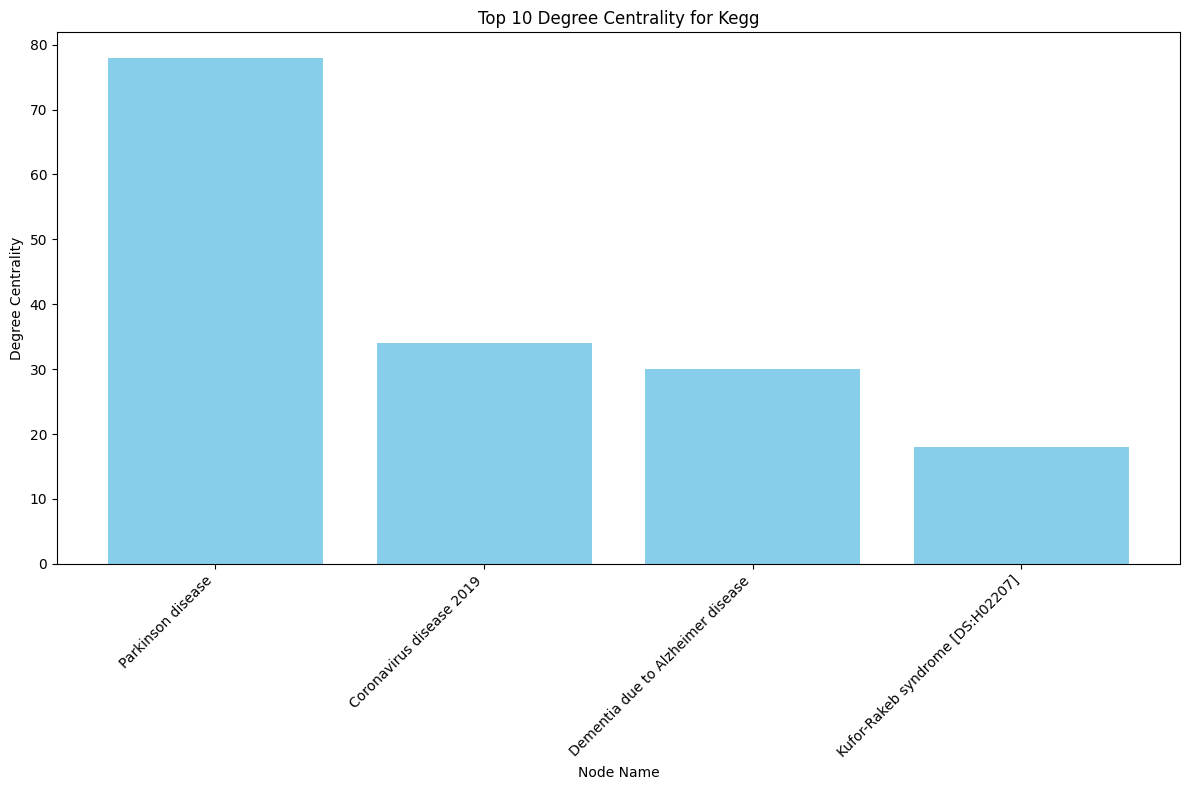

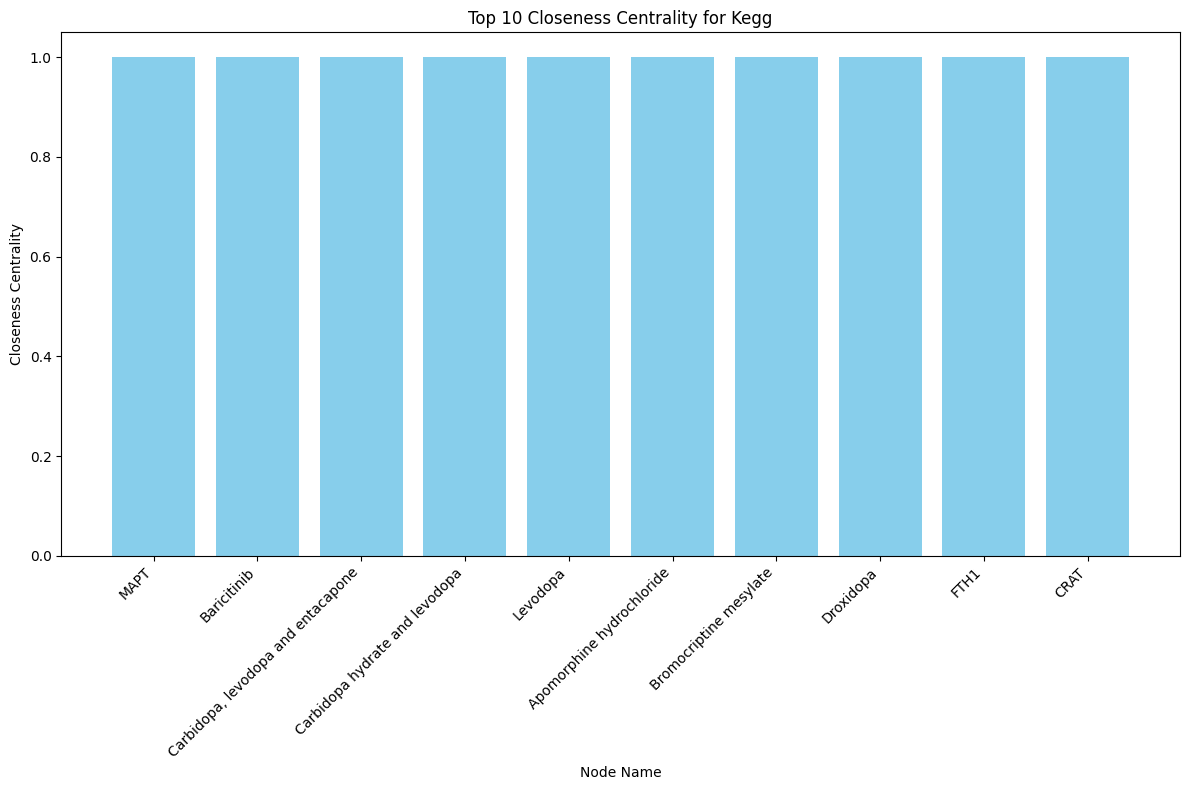

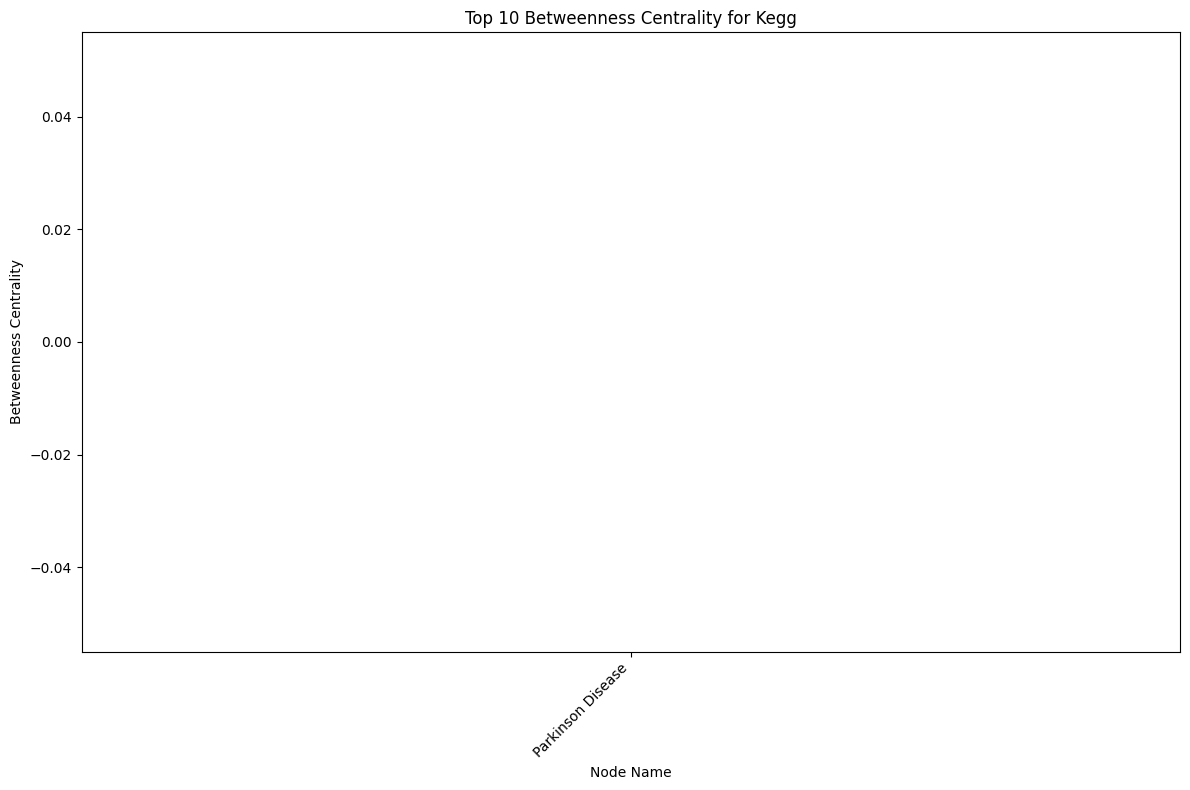

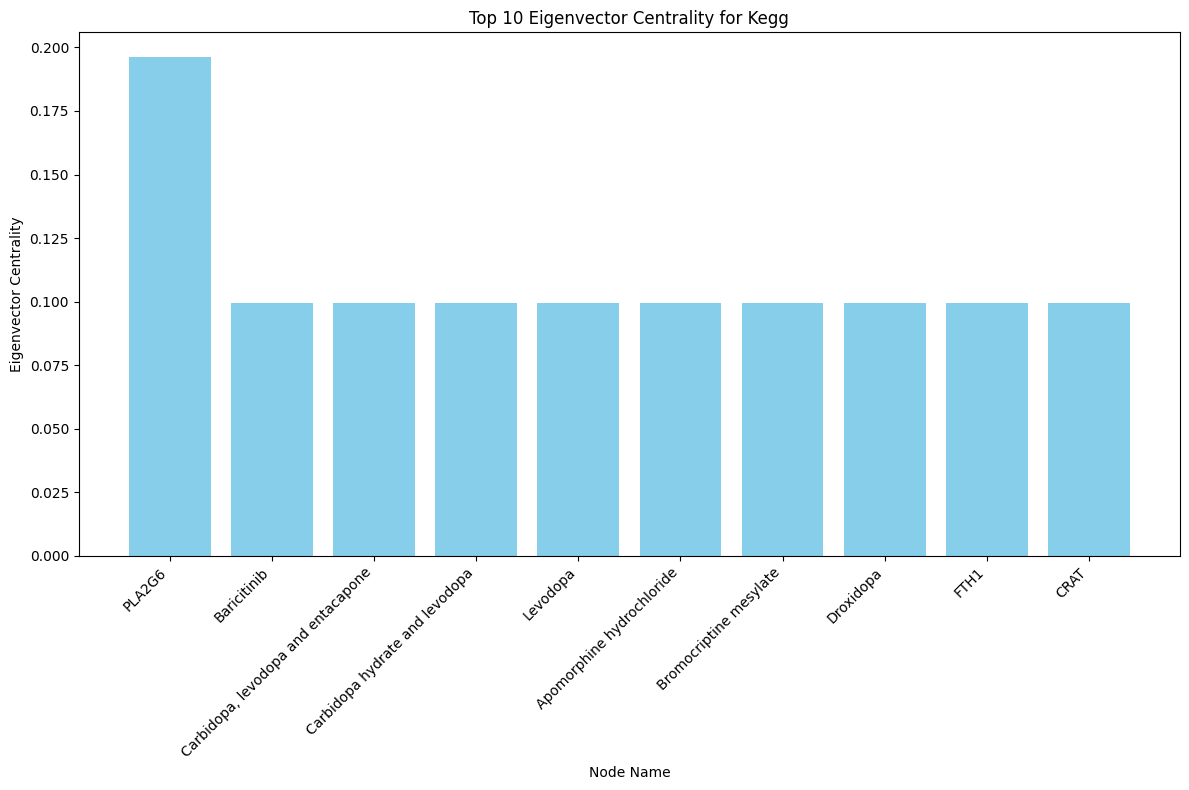

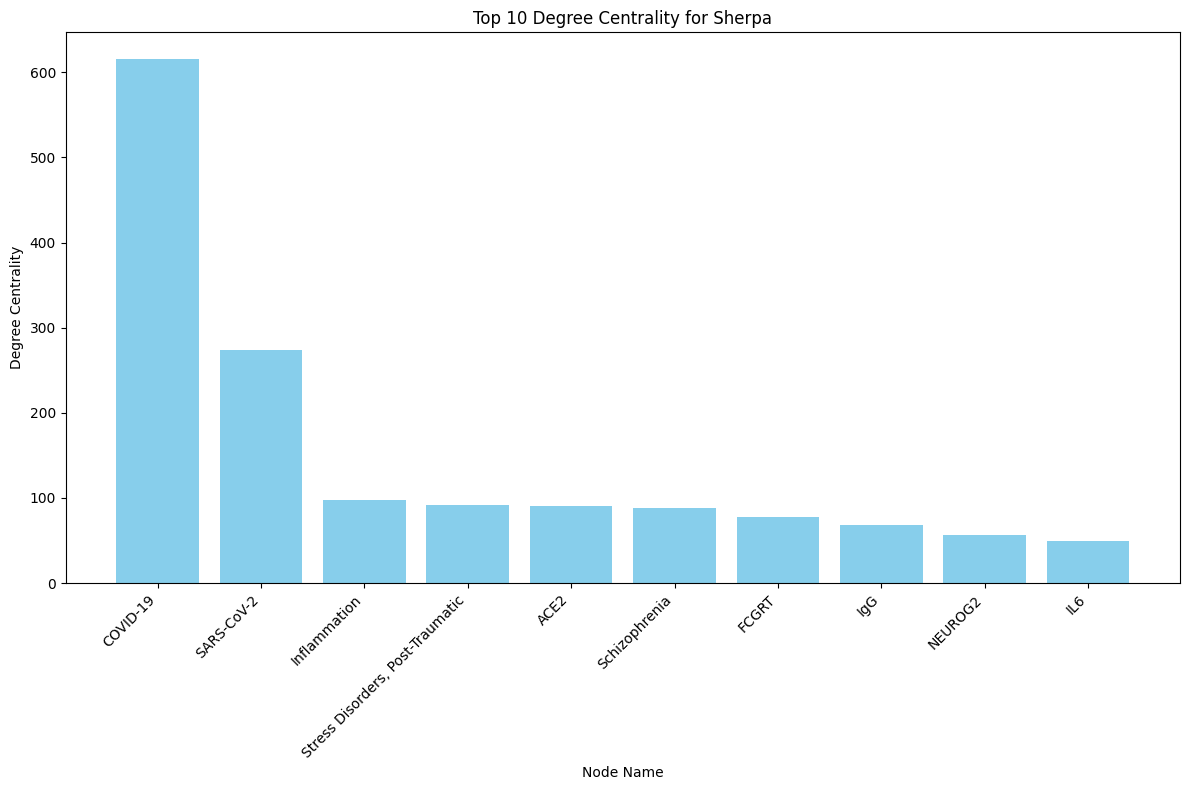

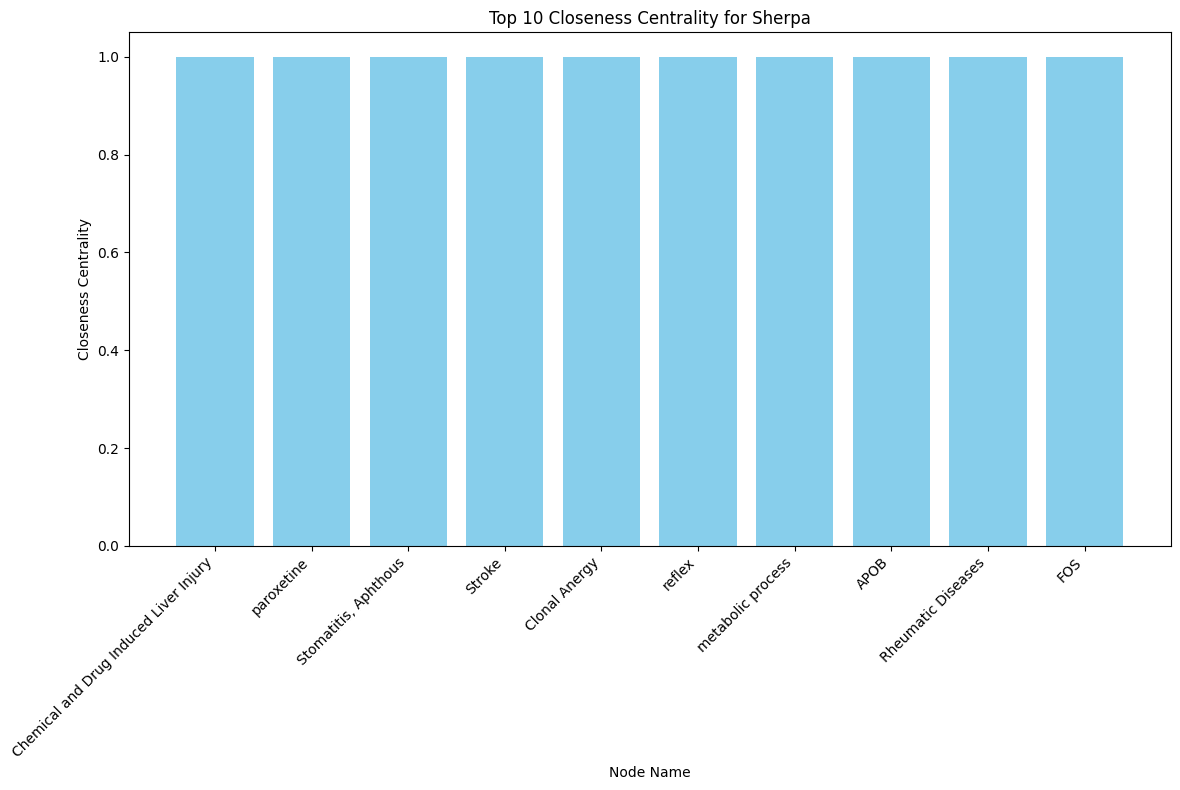

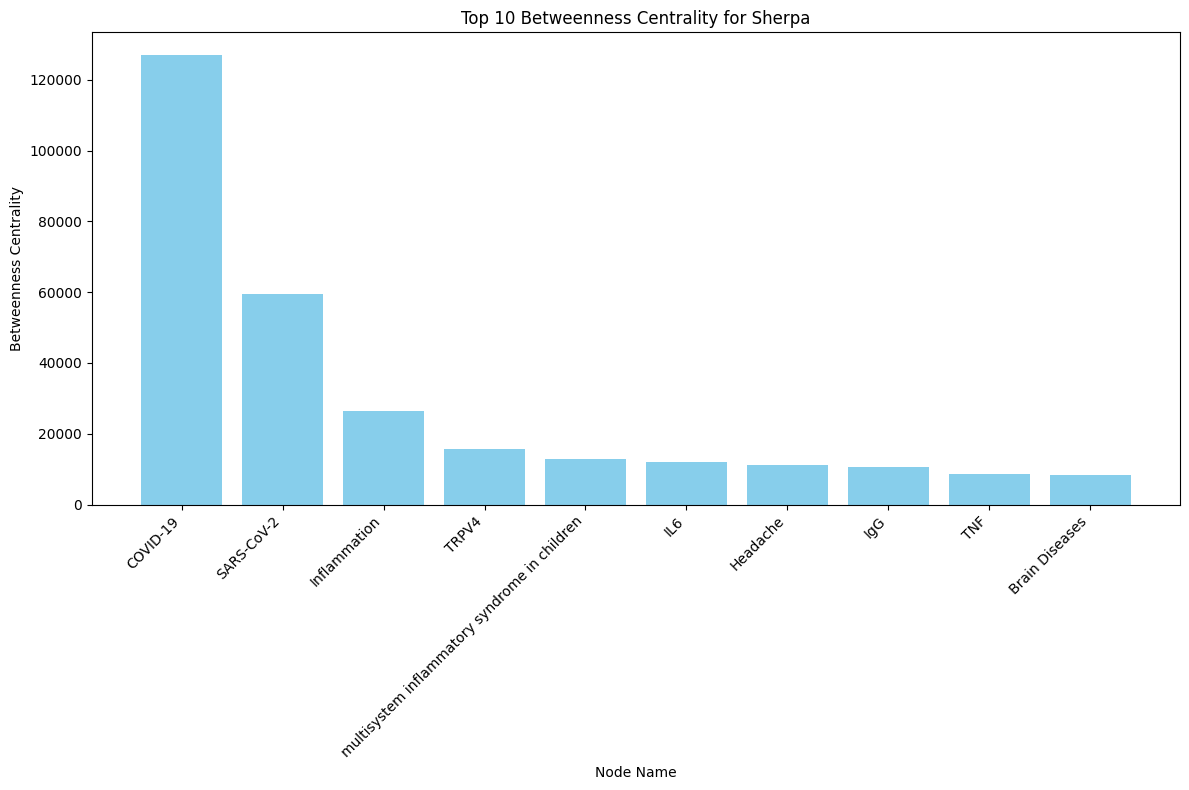

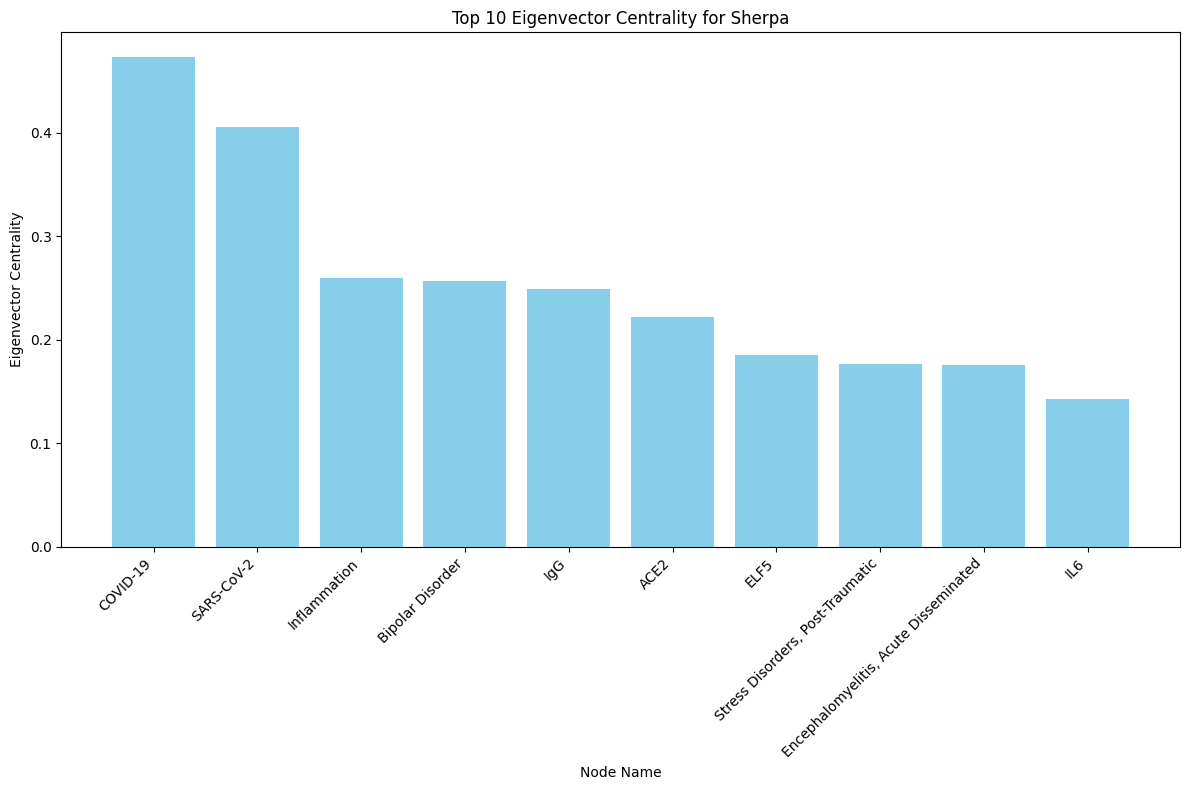

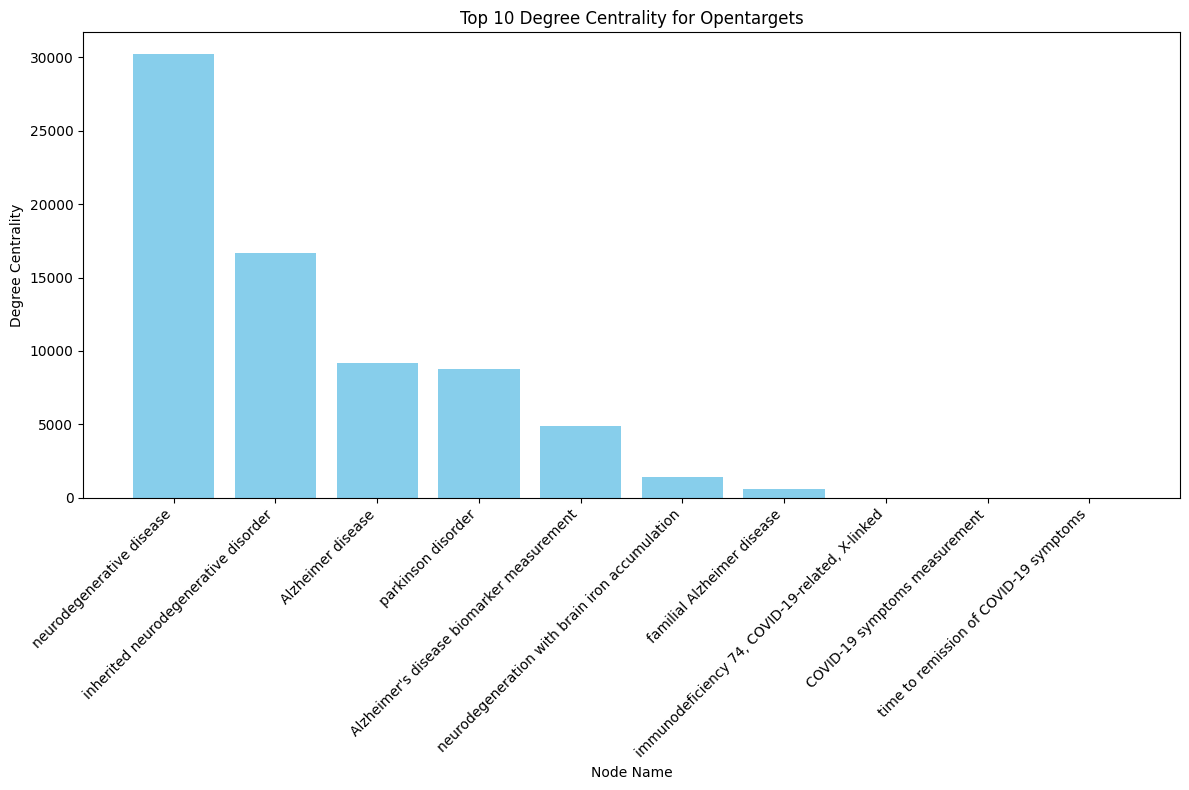

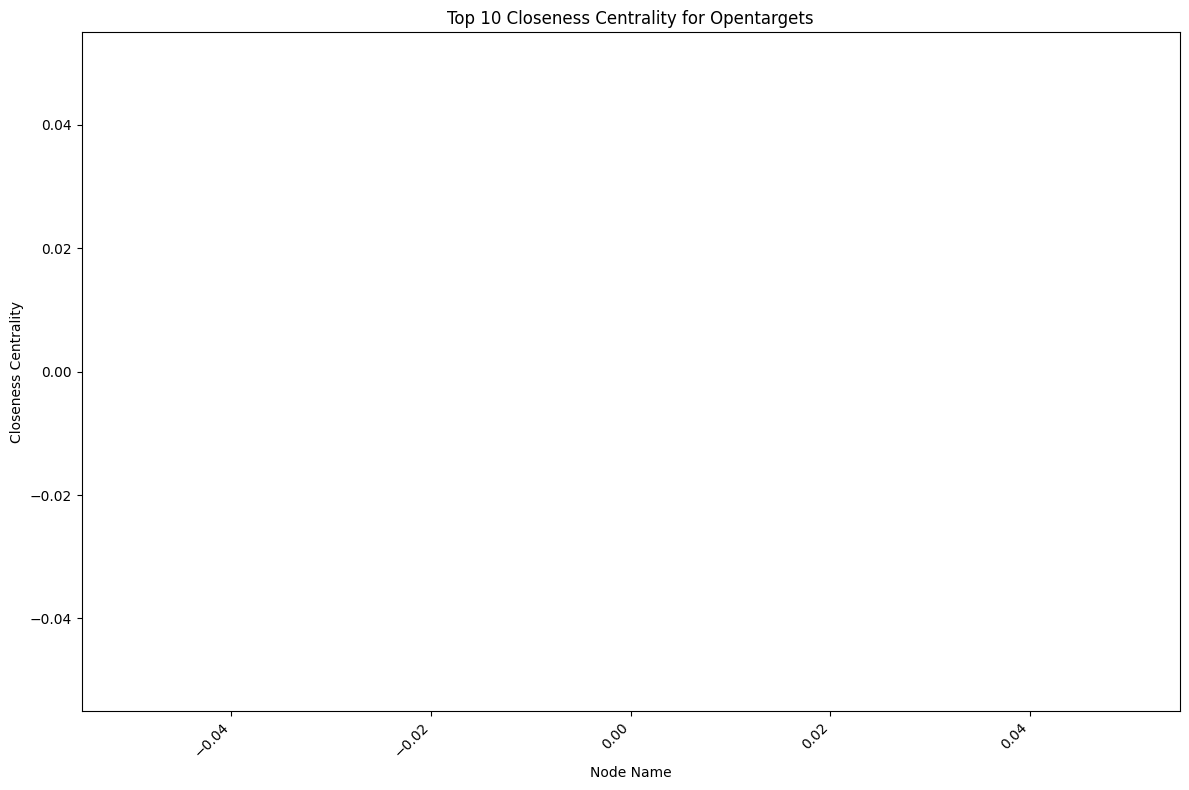

C:\Users\nbabaiha\AppData\Local\Temp\ipykernel_24180\1183857368.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_id'] = df['node_id'].astype(str)


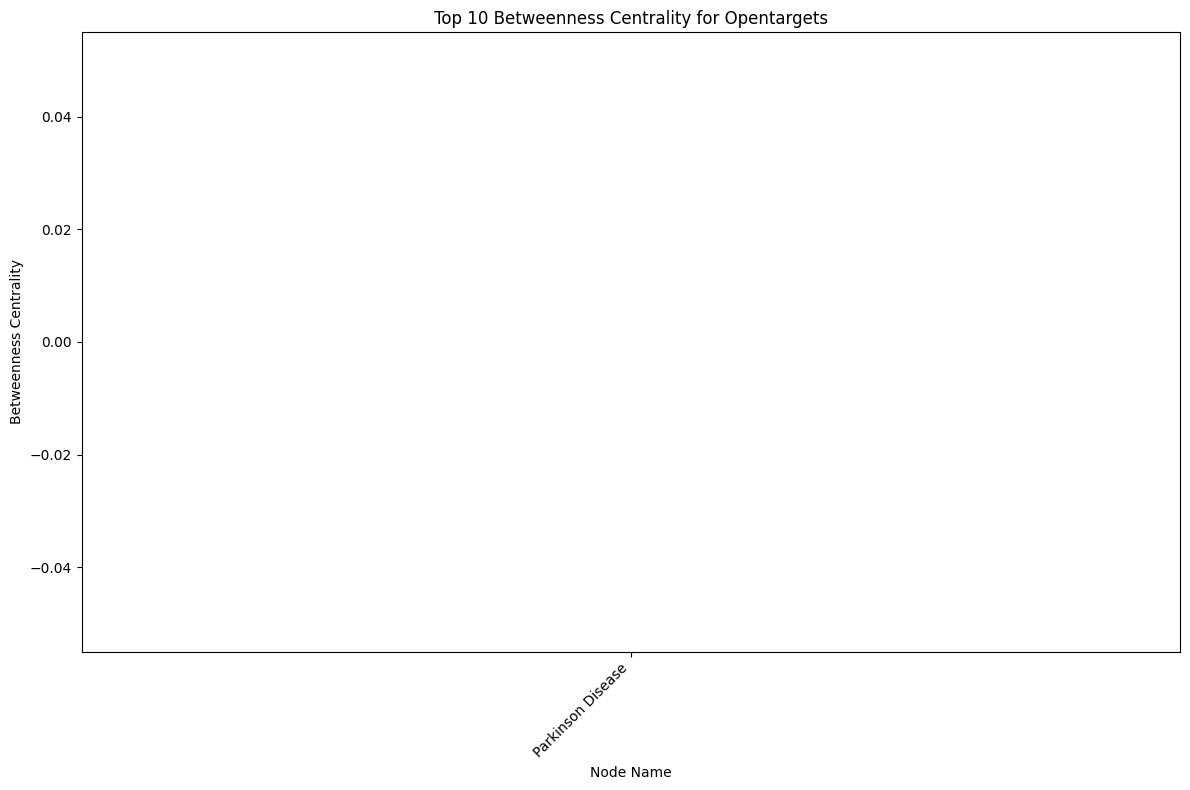

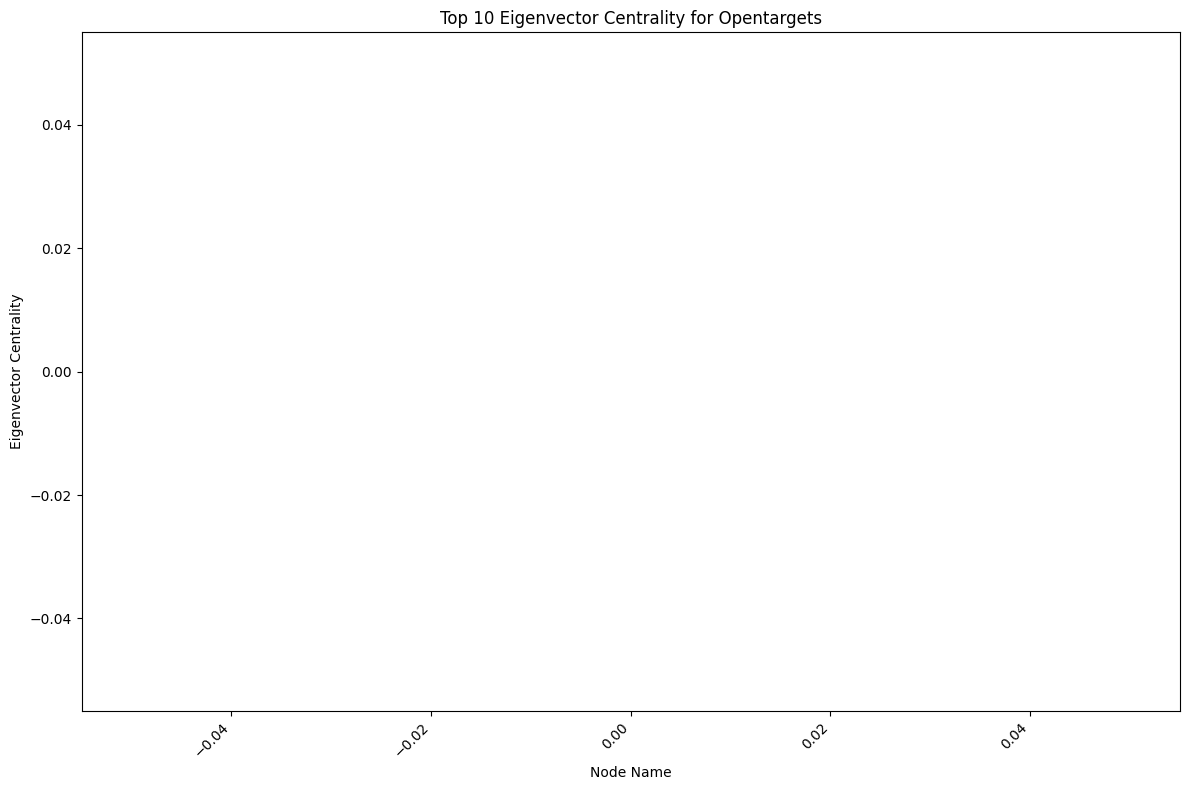

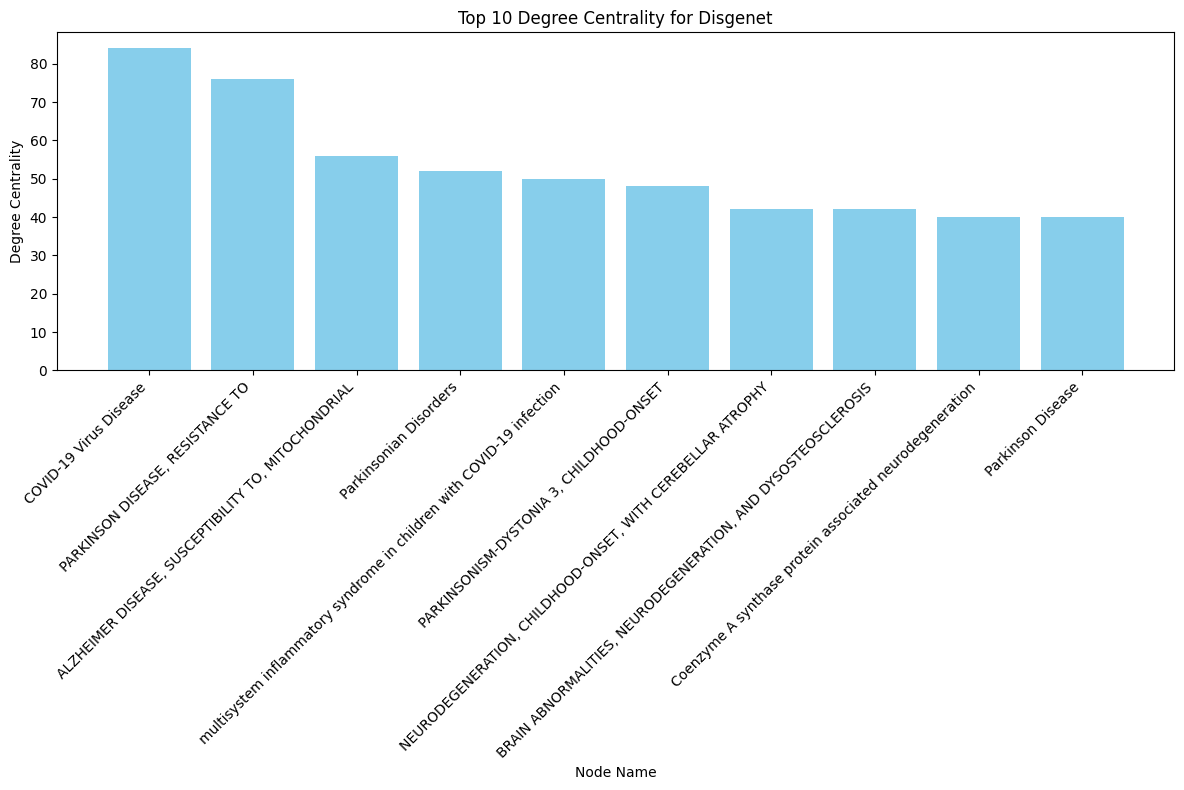

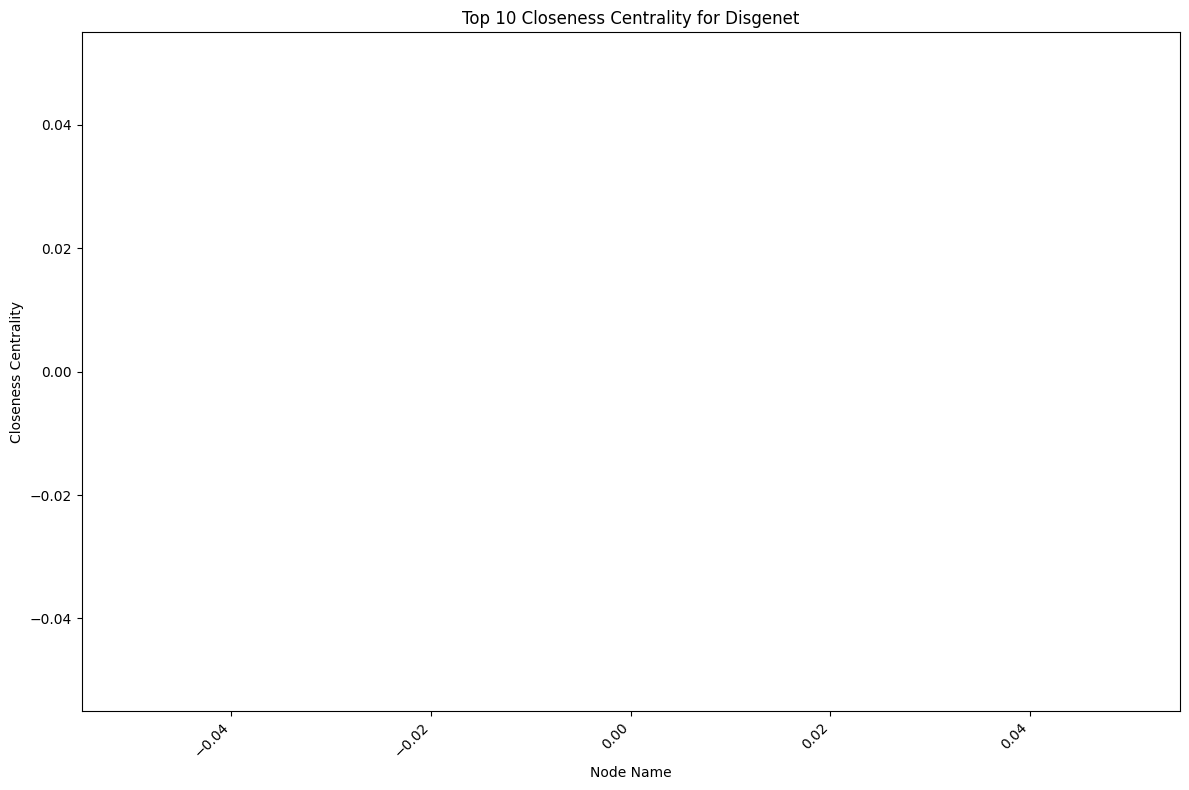

C:\Users\nbabaiha\AppData\Local\Temp\ipykernel_24180\1183857368.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_id'] = df['node_id'].astype(str)


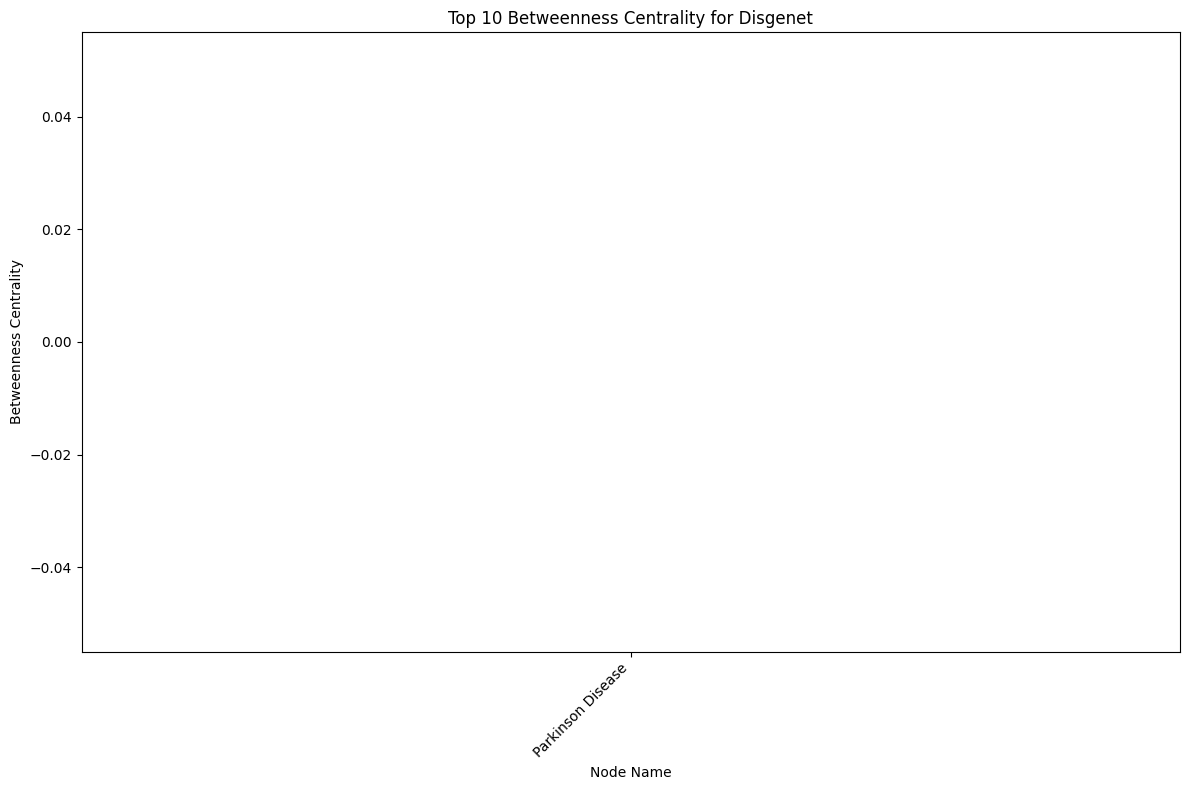

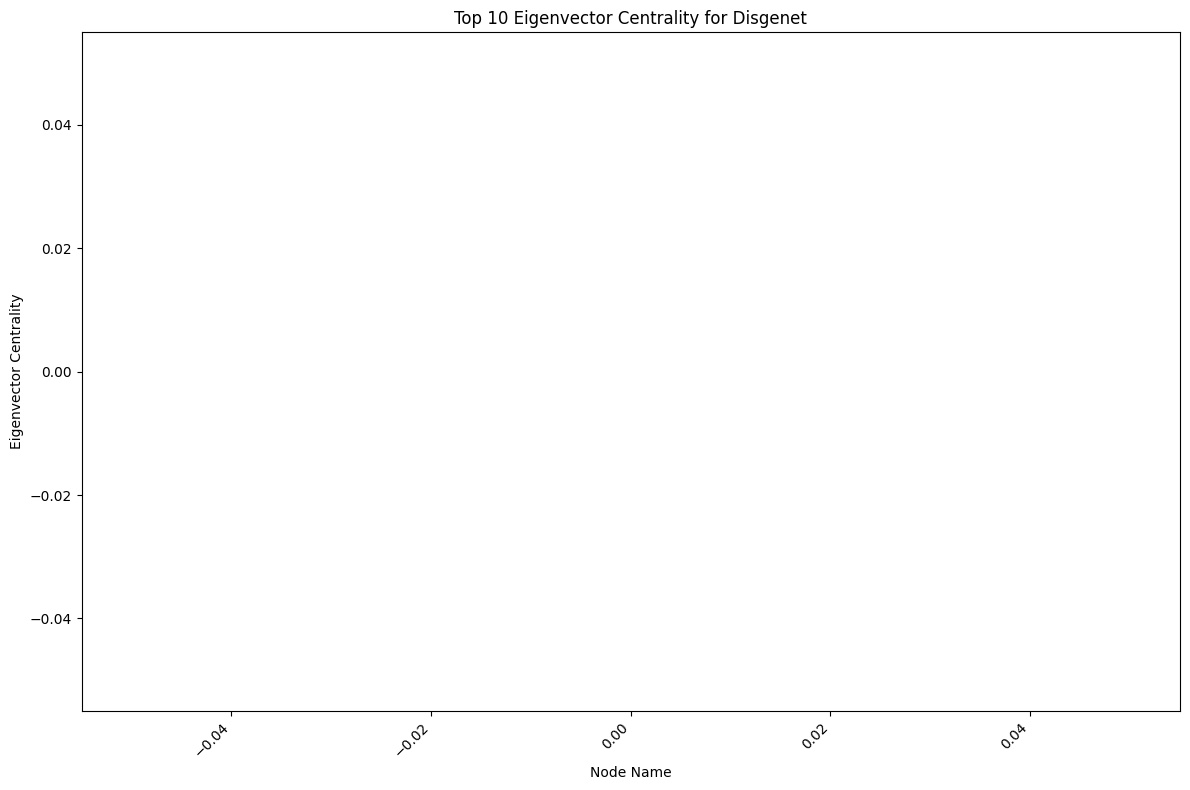

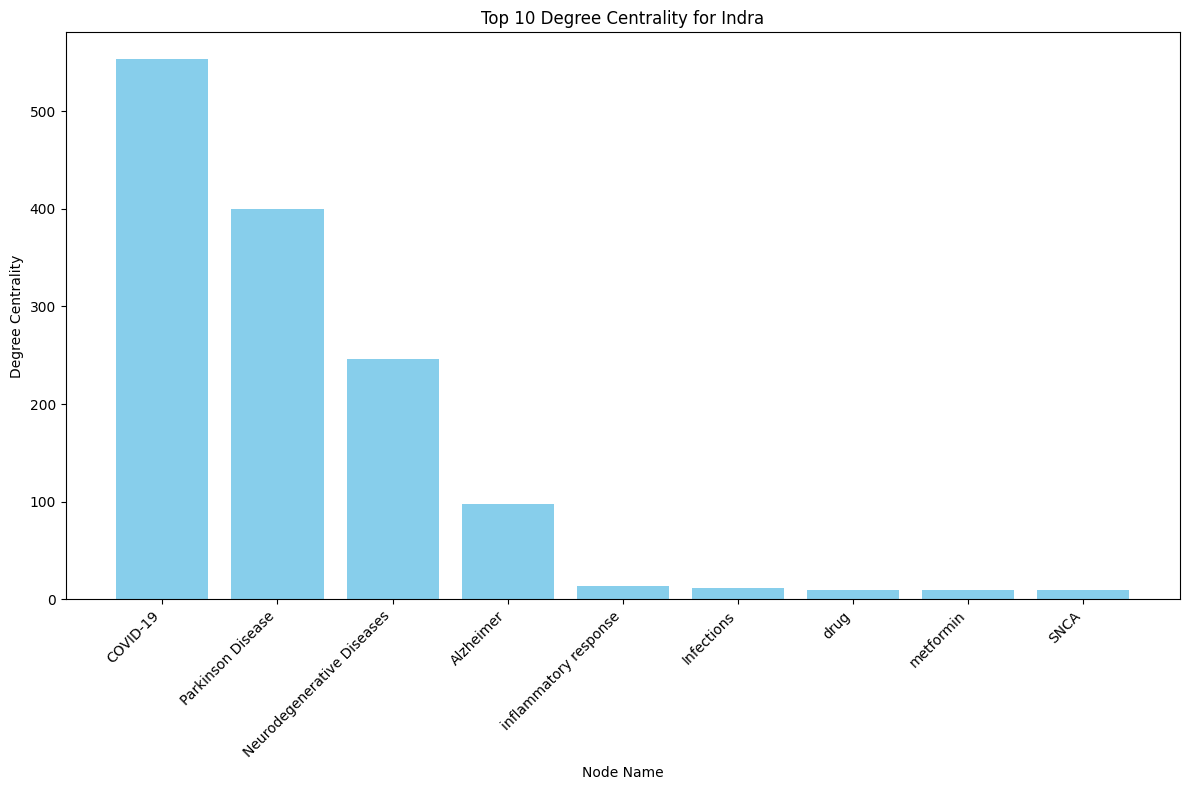

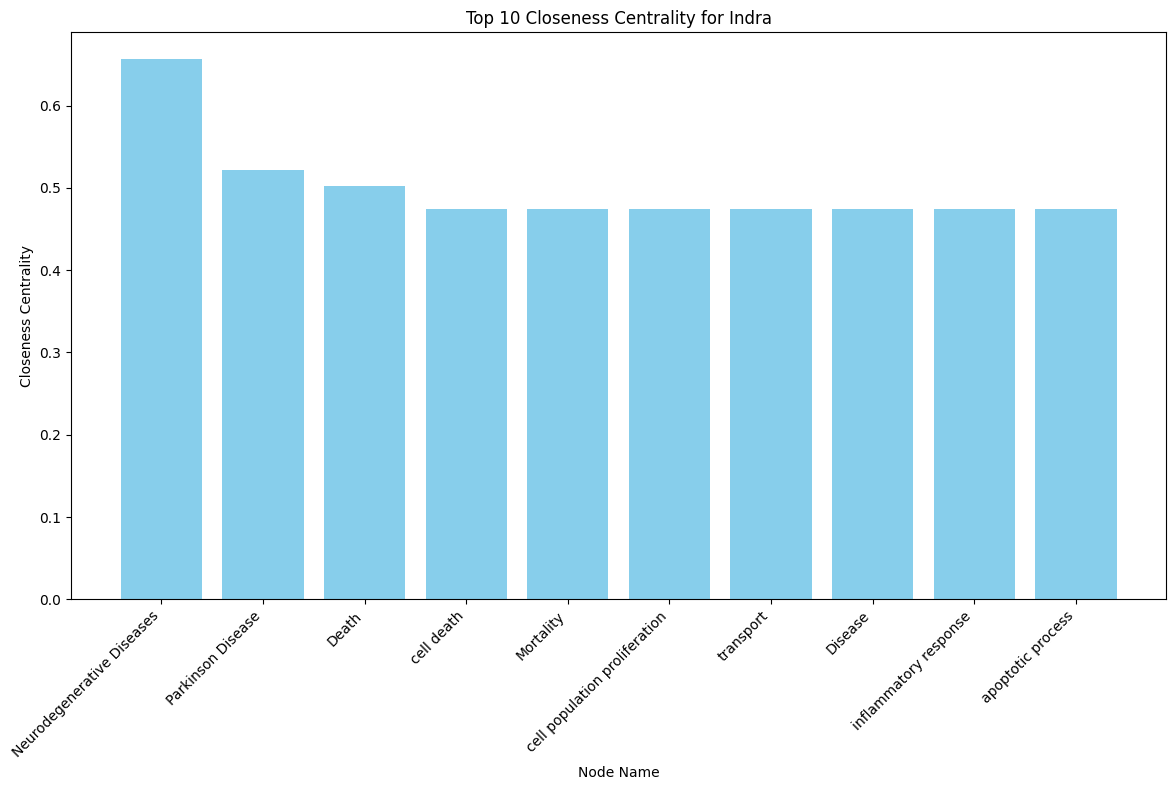

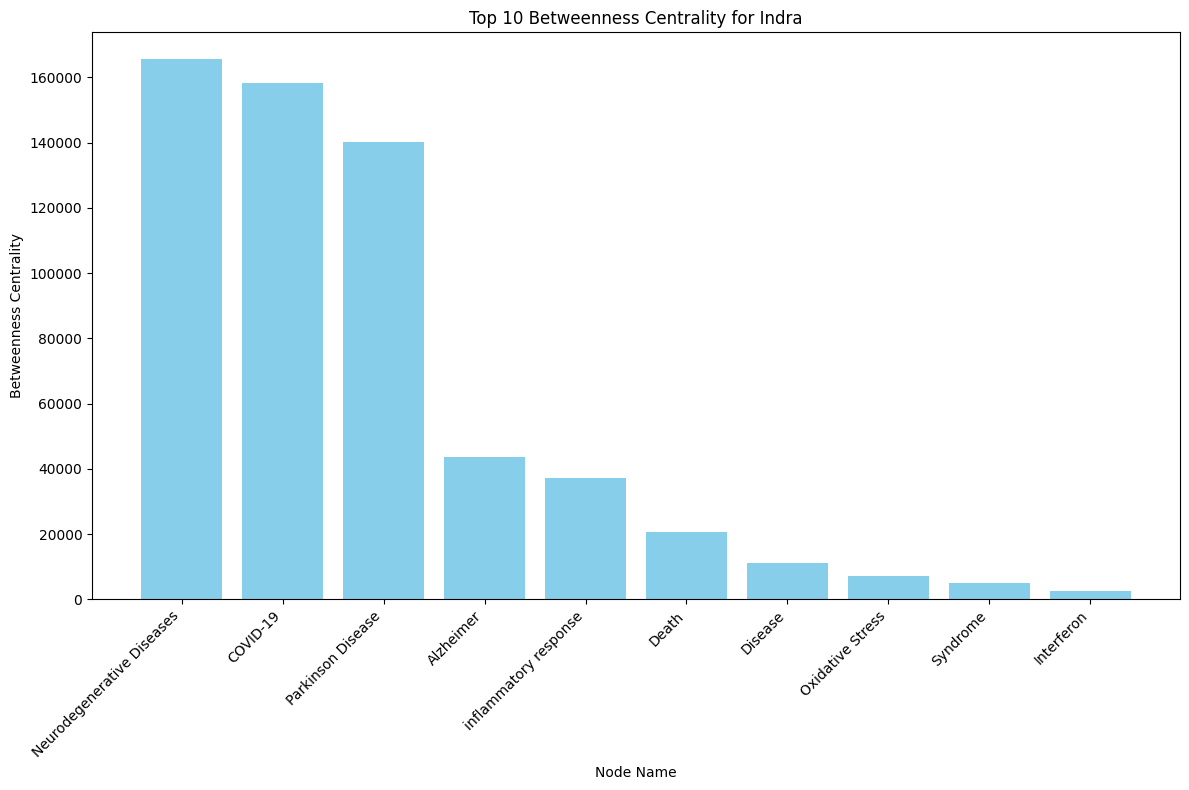

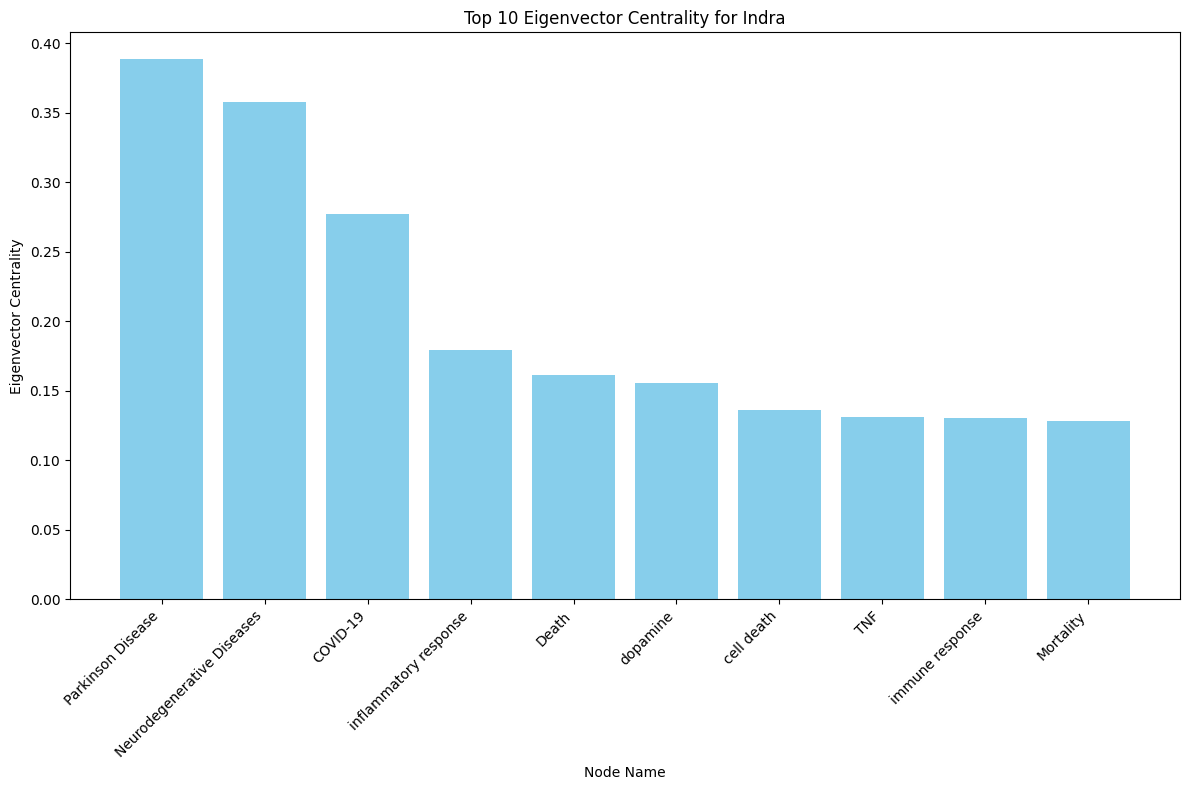

C:\Users\nbabaiha\AppData\Local\Temp\ipykernel_24180\1183857368.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_id'] = df['node_id'].astype(str)


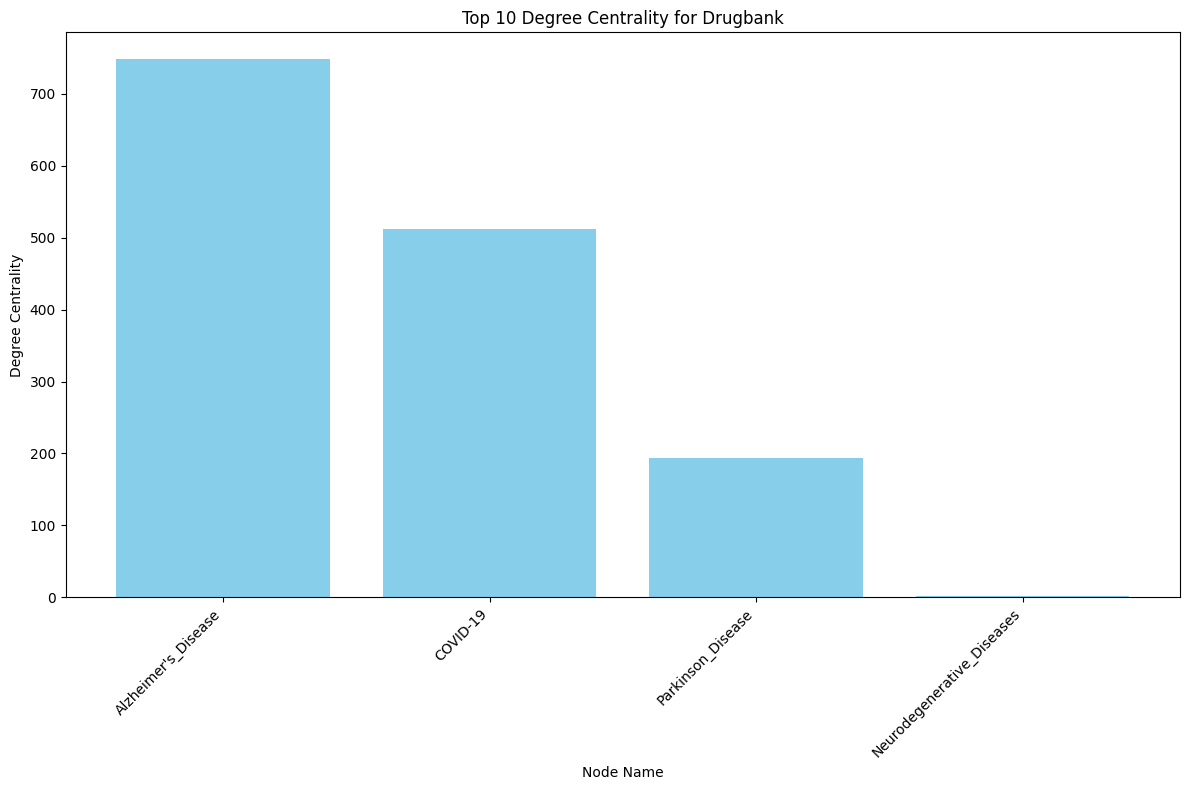

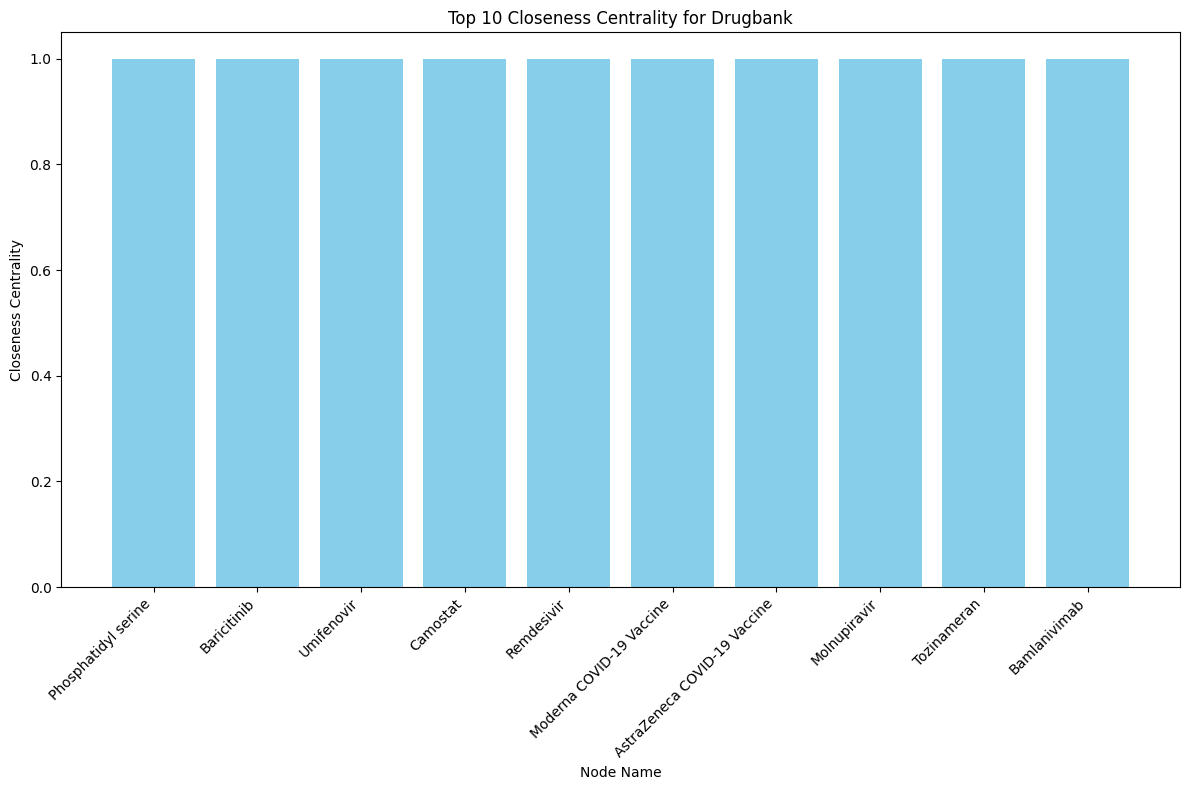

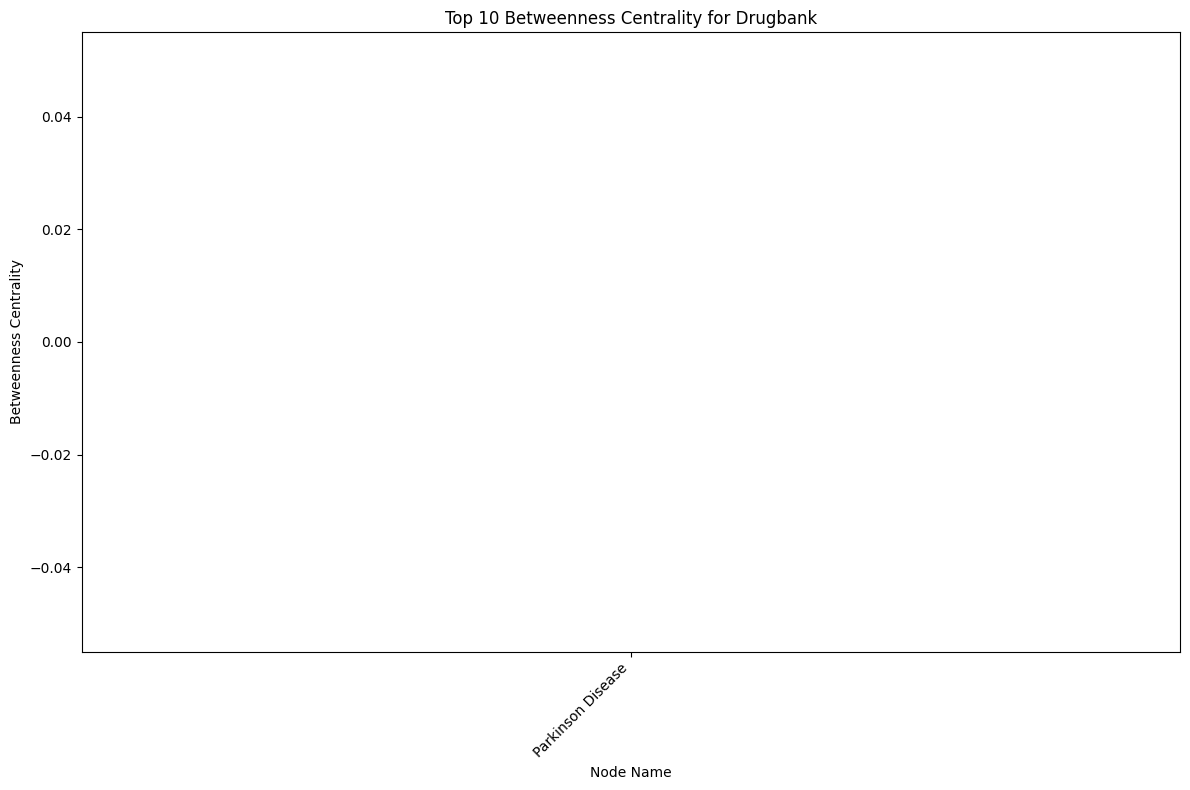

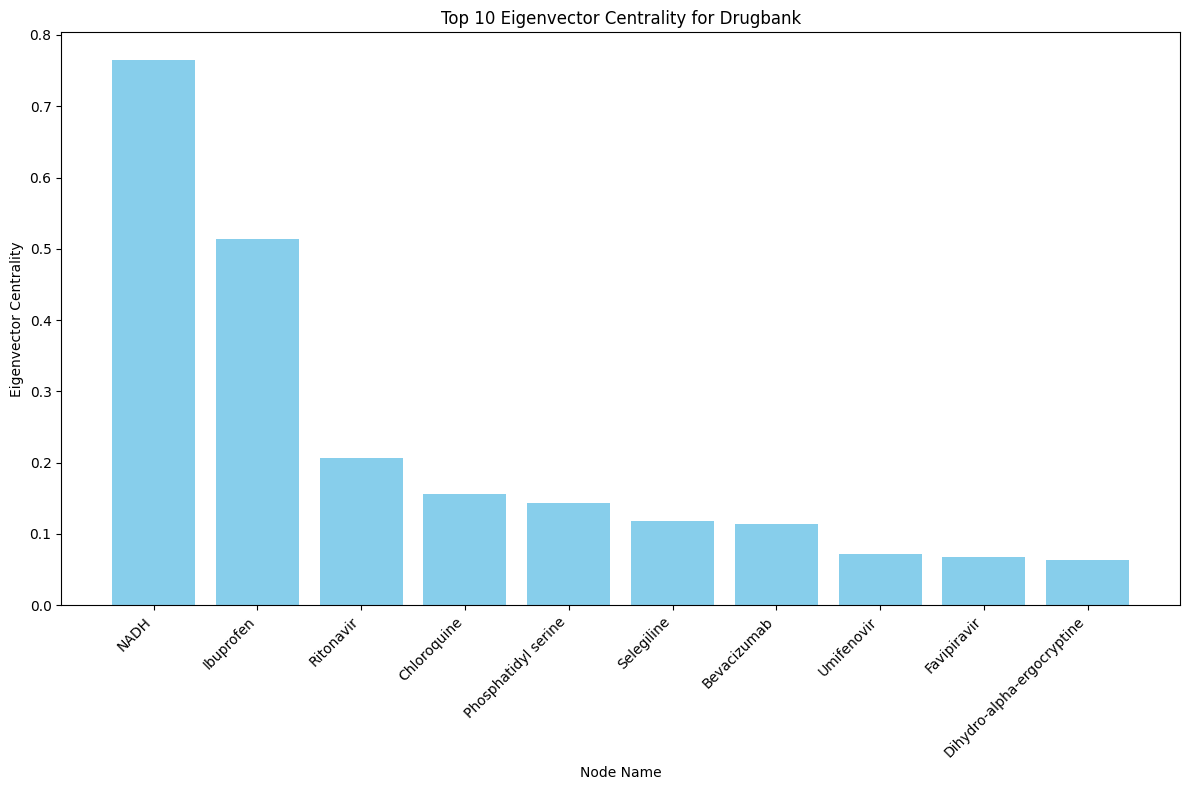

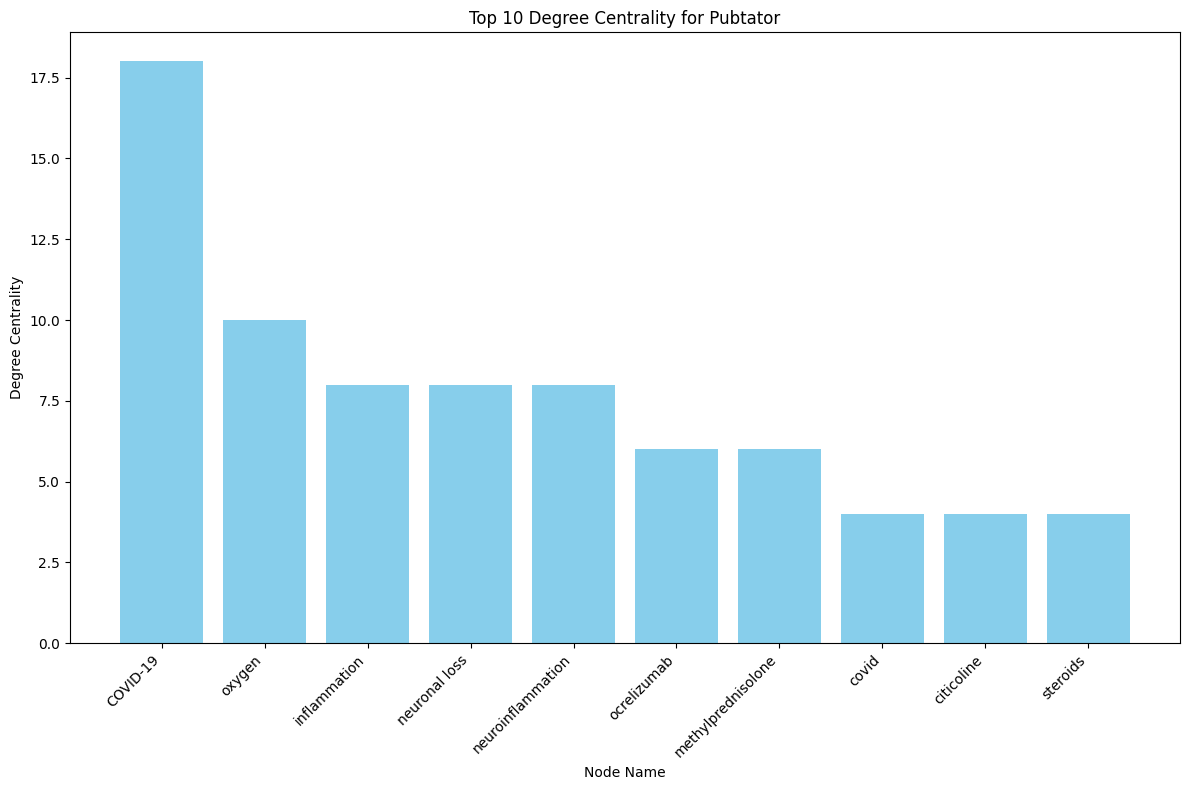

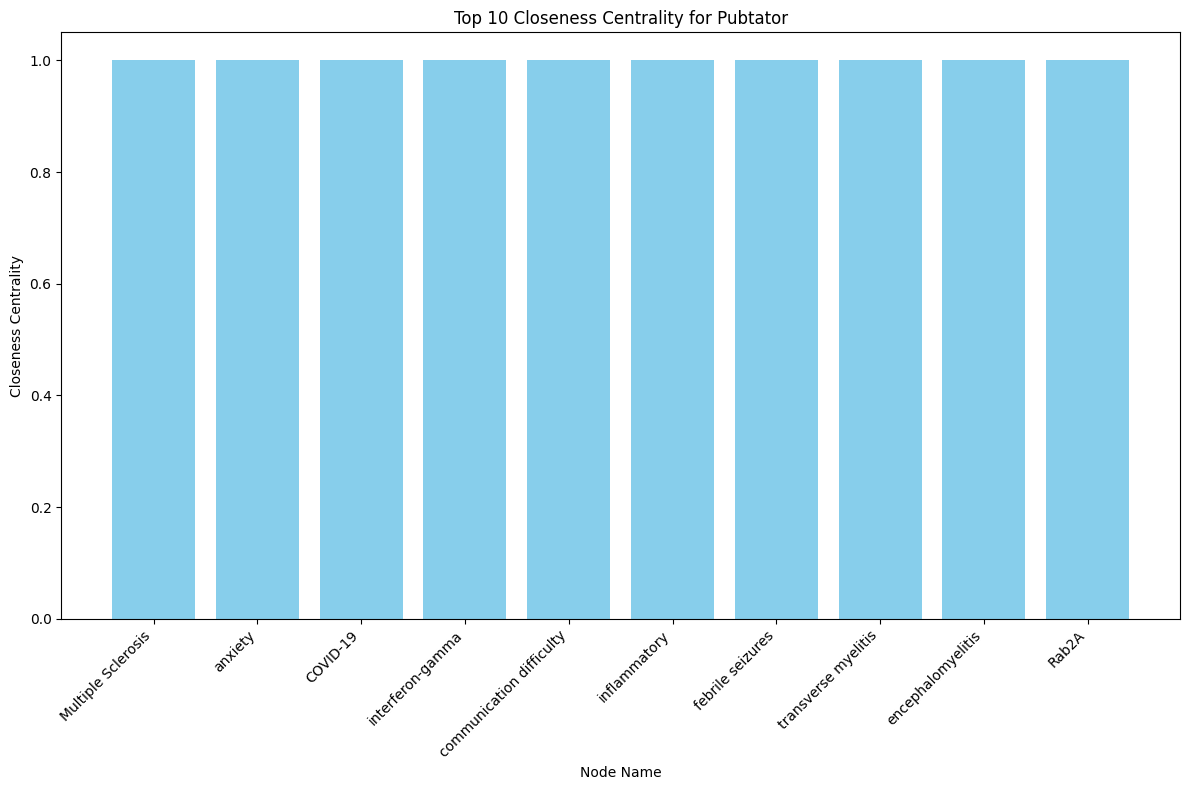

C:\Users\nbabaiha\AppData\Local\Temp\ipykernel_24180\1183857368.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_id'] = df['node_id'].astype(str)


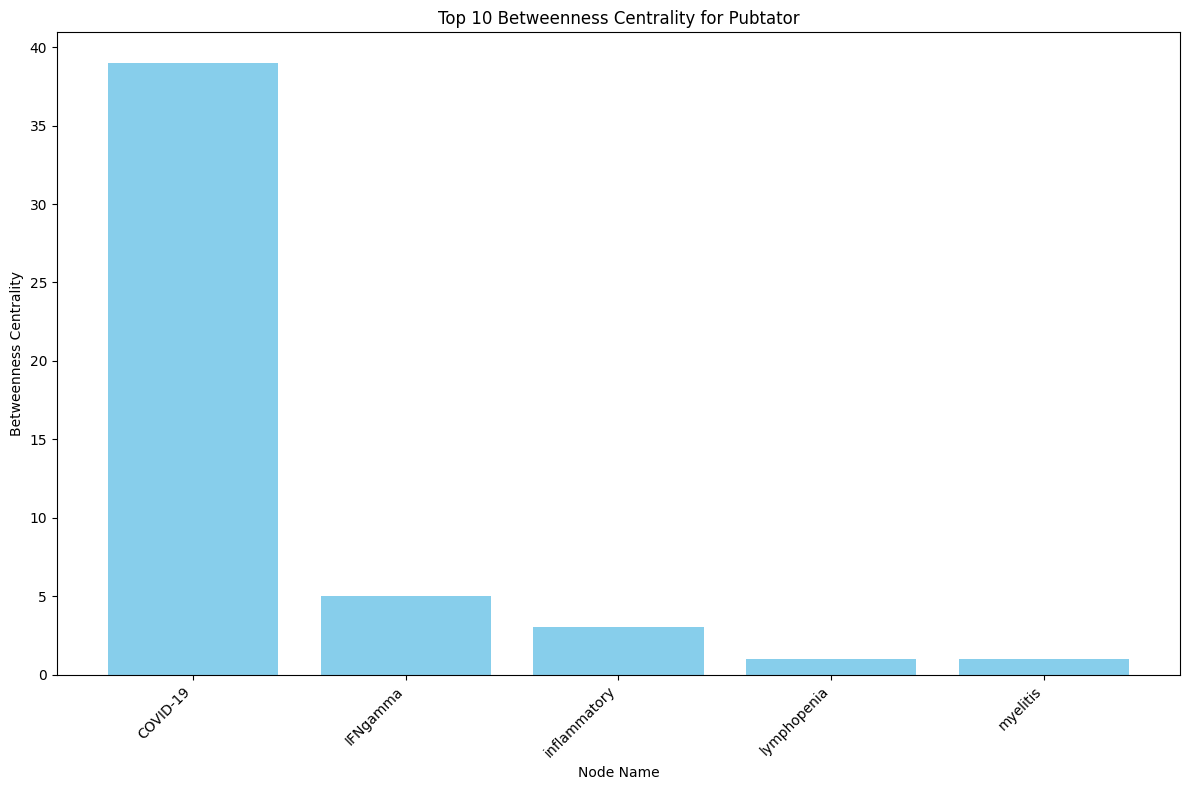

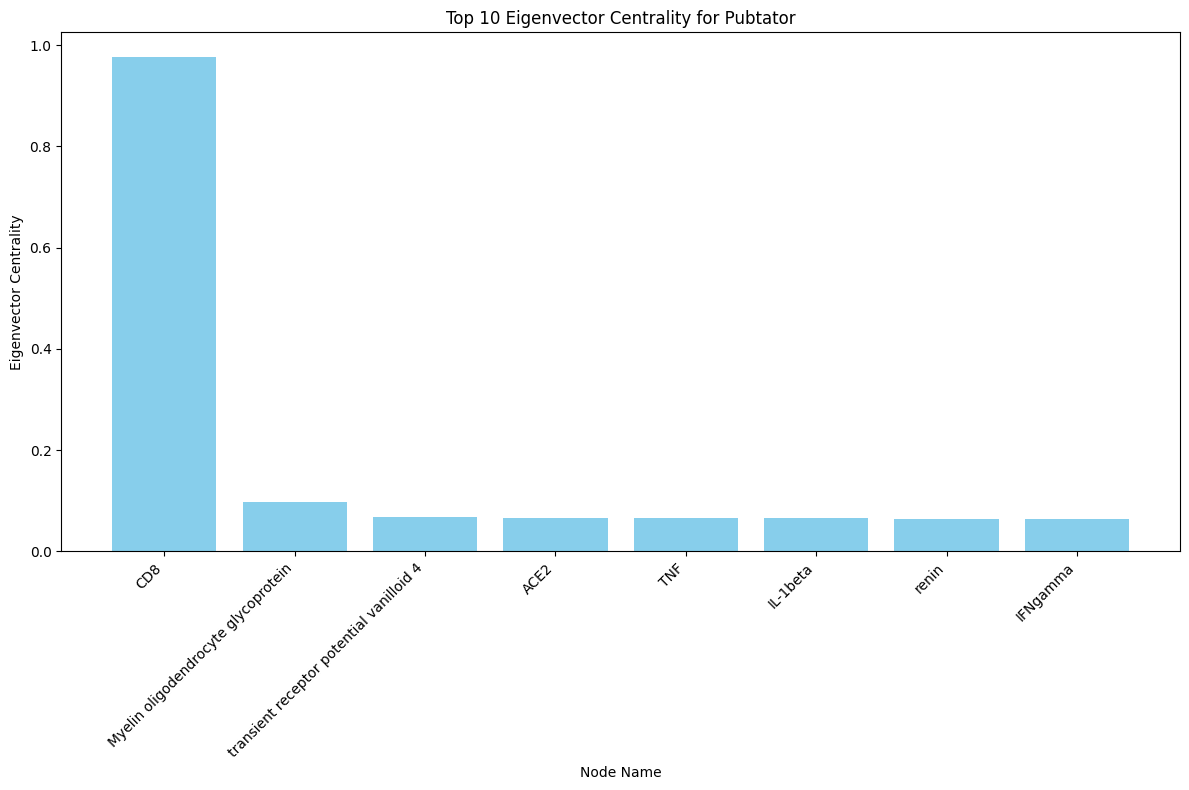

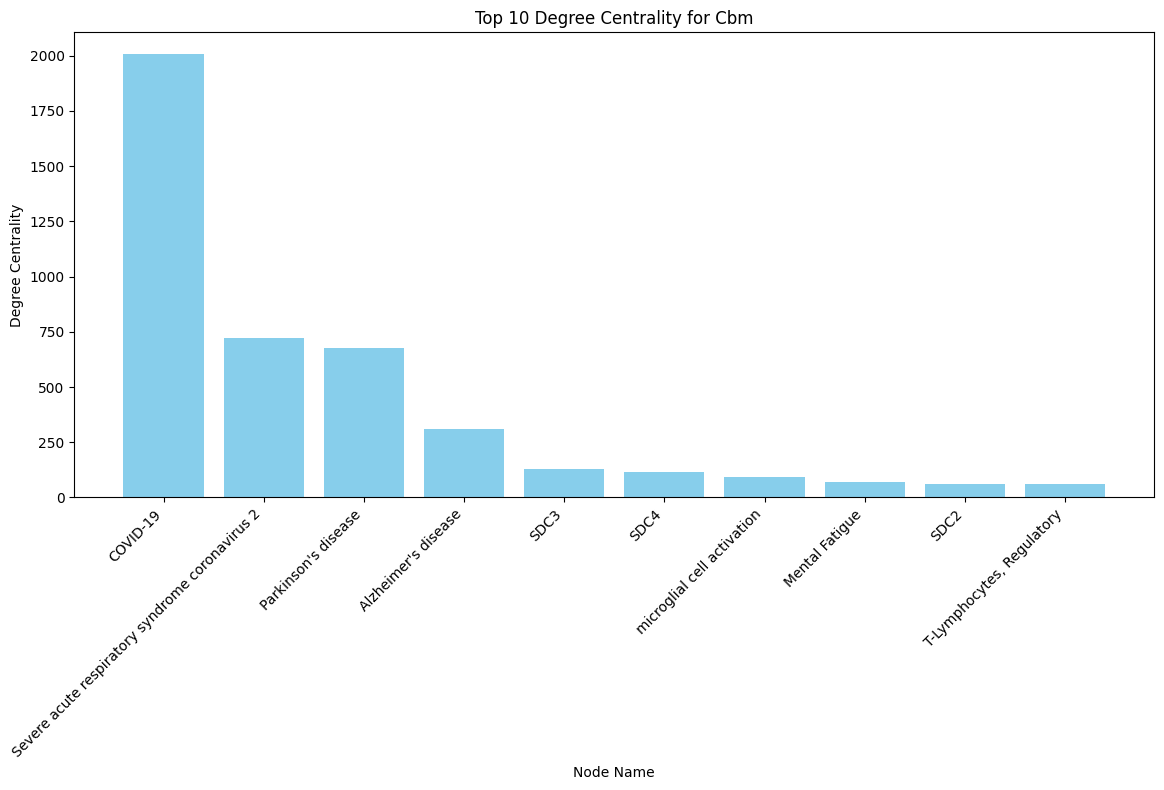

C:\Users\nbabaiha\AppData\Local\Temp\ipykernel_24180\1183857368.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_id'] = df['node_id'].astype(str)


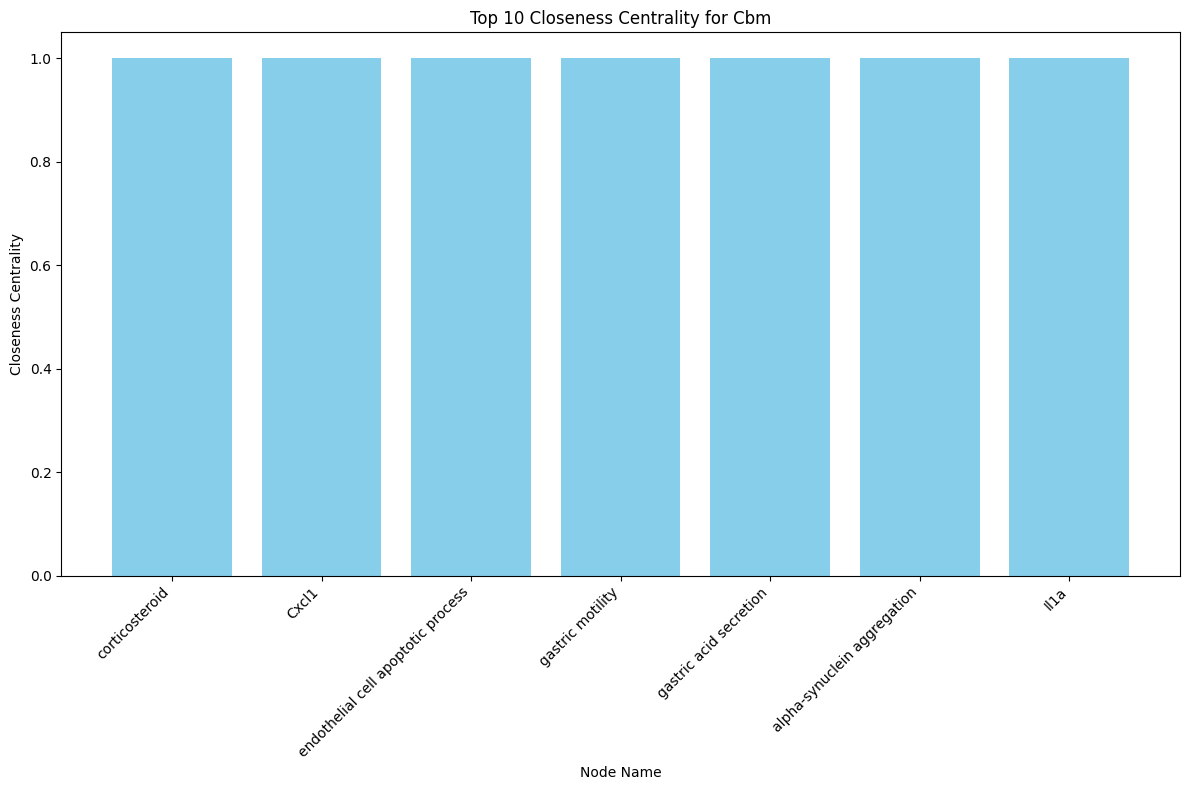

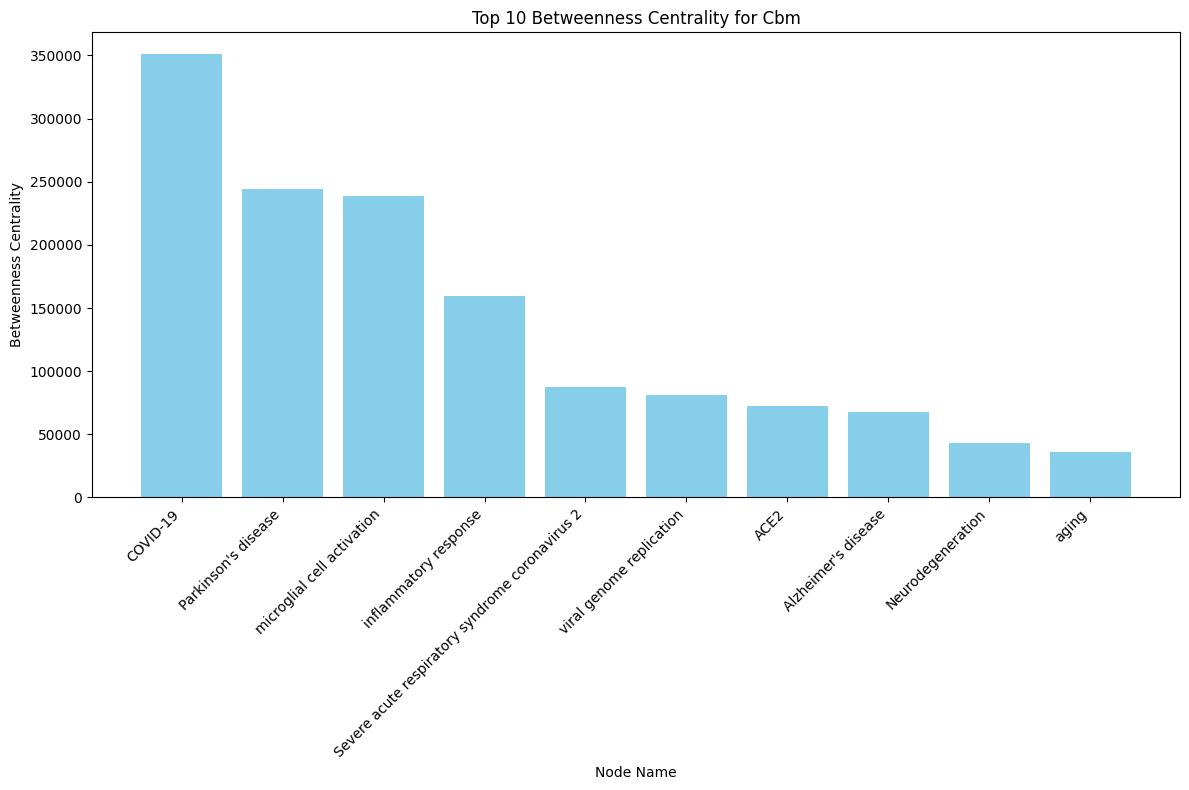

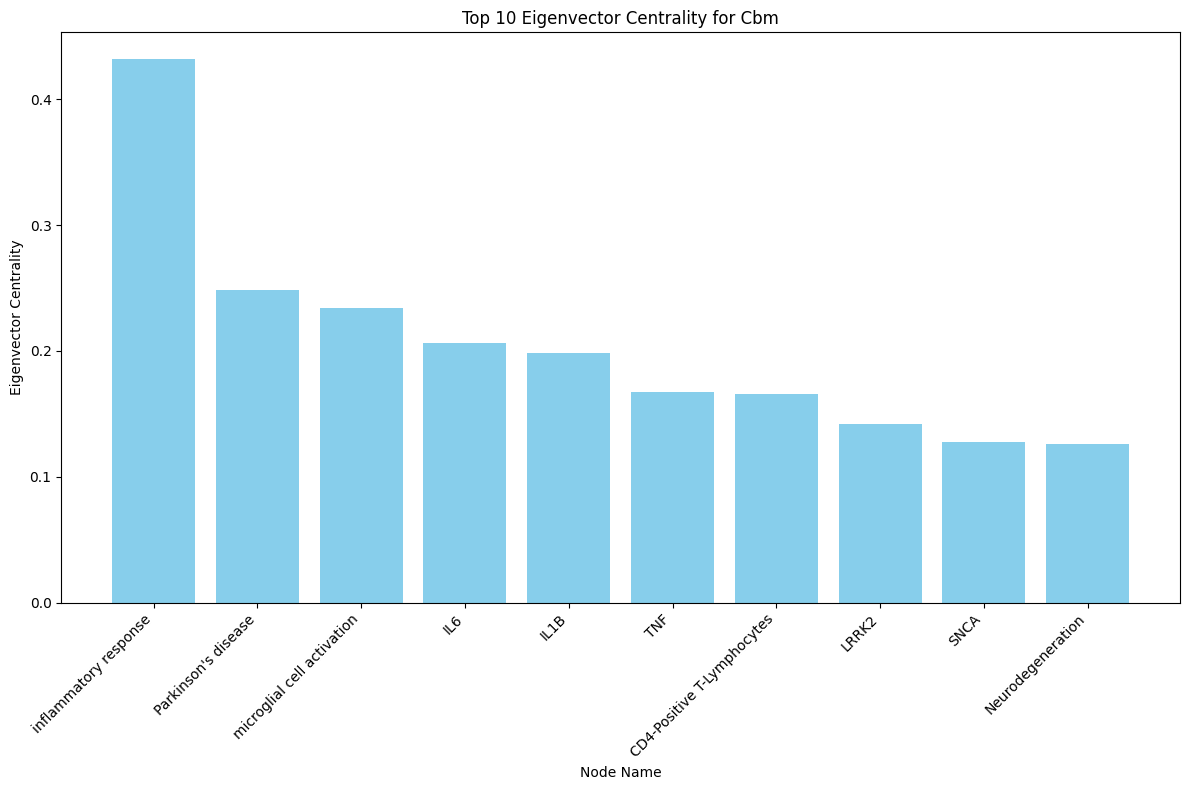

C:\Users\nbabaiha\AppData\Local\Temp\ipykernel_24180\1183857368.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node_id'] = df['node_id'].astype(str)


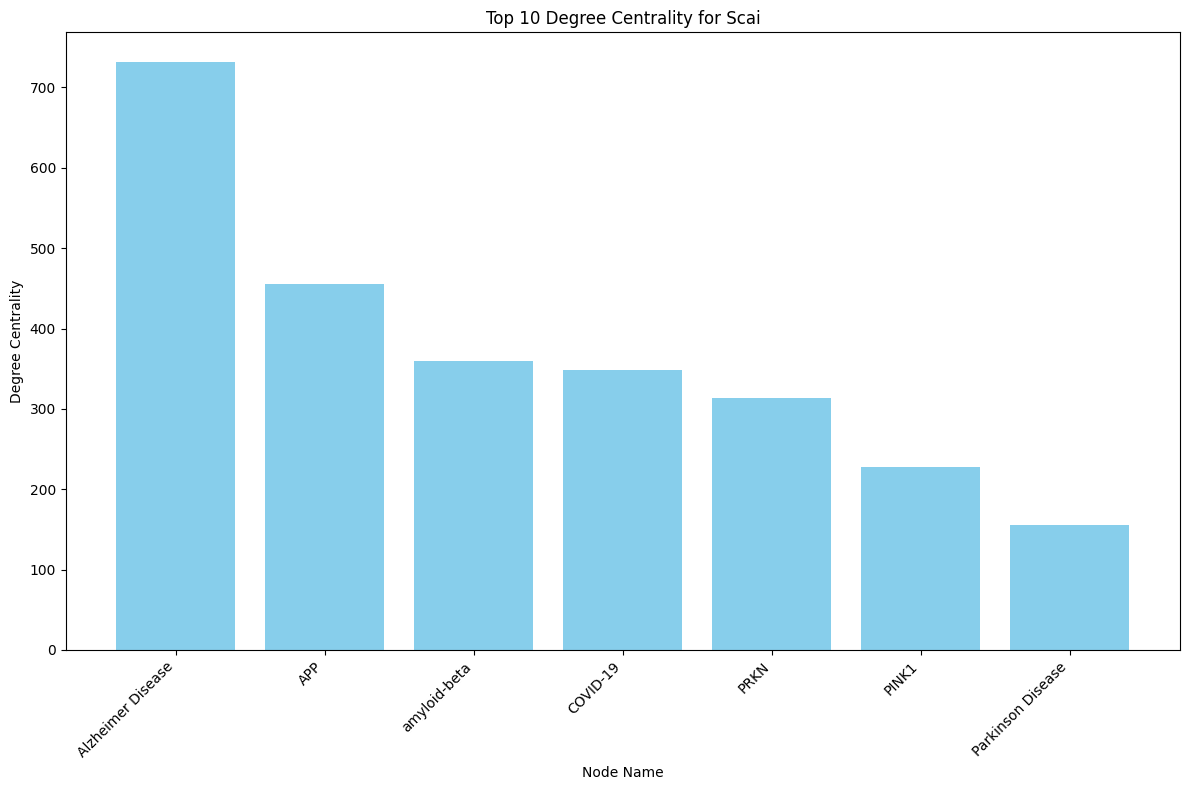

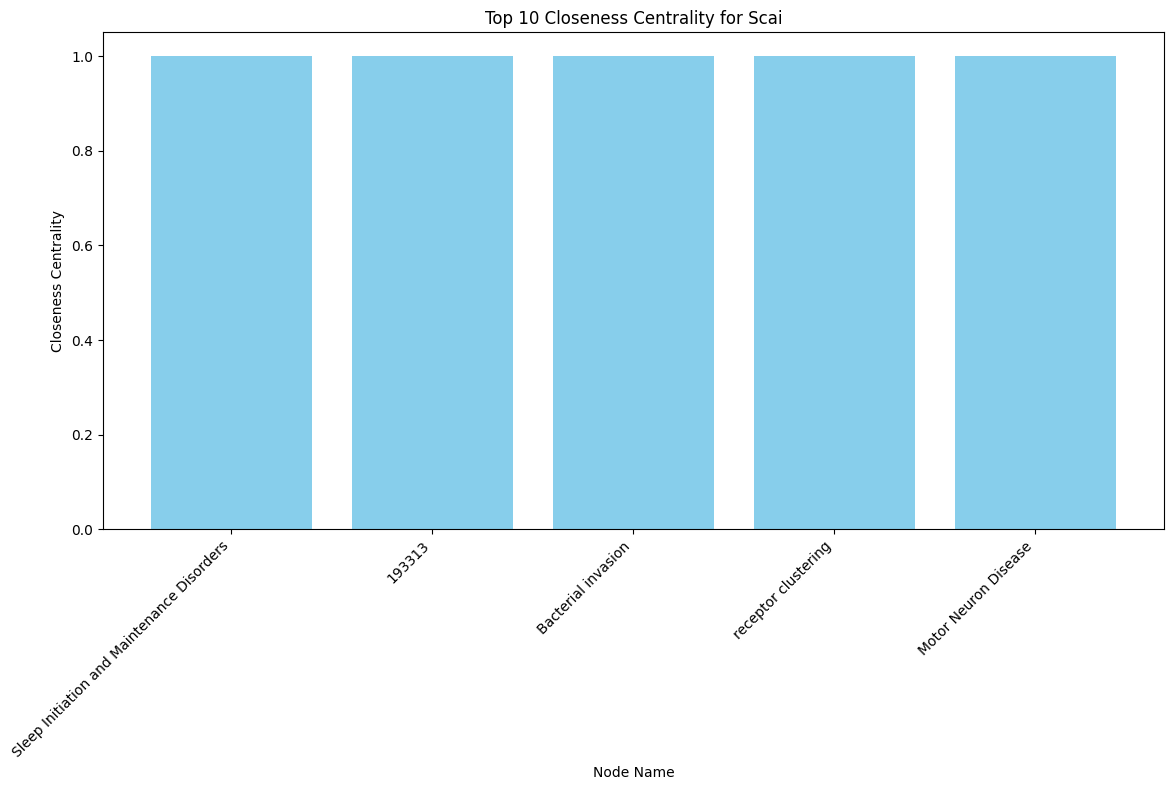

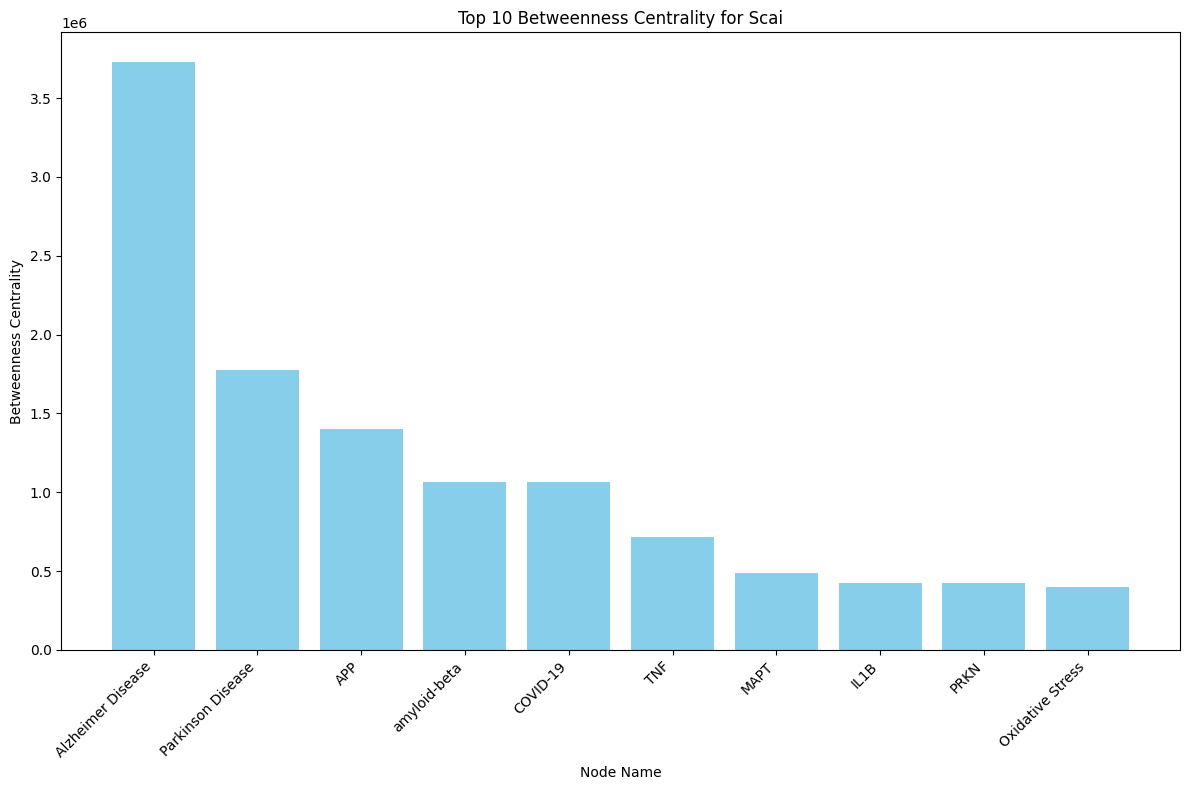

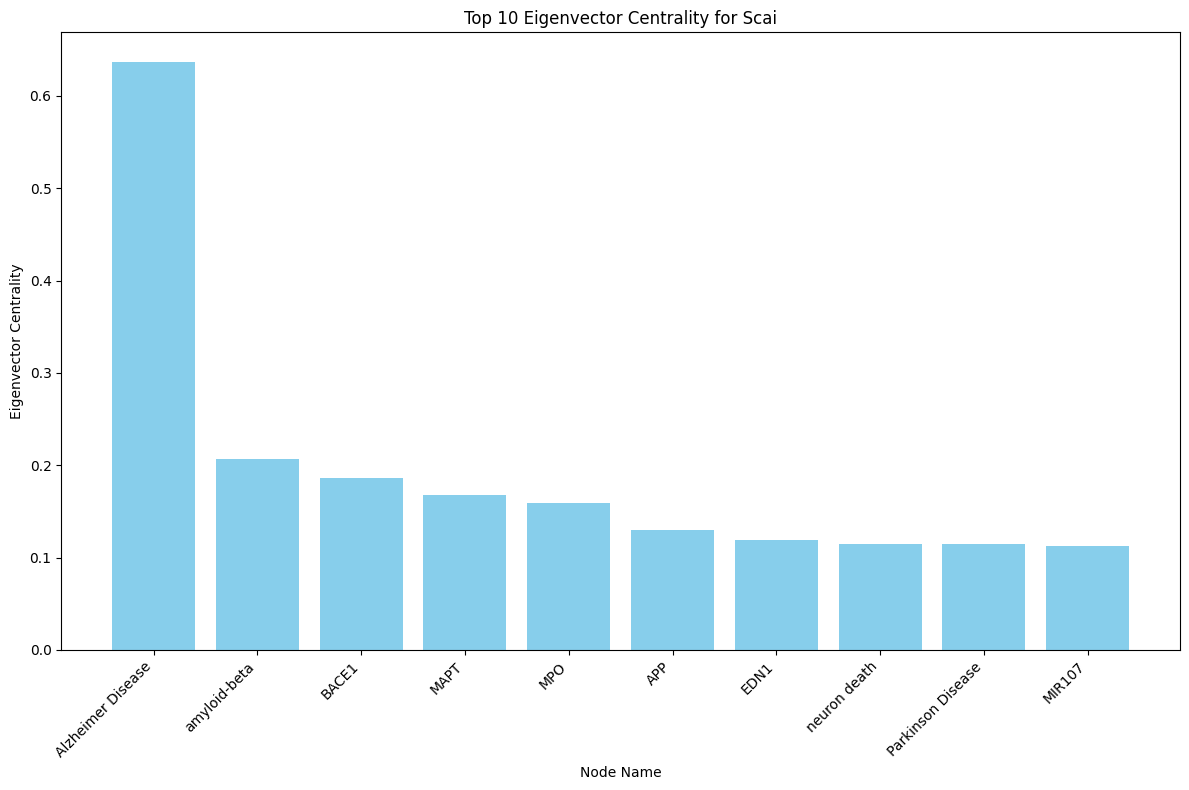

In [1]:
# Centrality measure (various types) and bar charts for each source
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Define connection parameters
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(user, password))

def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters=parameters)
        return [record for record in result]

# Function to check if a graph exists
def graph_exists(graph_name):
    query = f"CALL gds.graph.exists('{graph_name}') YIELD exists"
    result = execute_query(query)
    return result[0]['exists'] if result else False

# Function to drop the graph projection if it exists
def drop_graph_if_exists(graph_name):
    if graph_exists(graph_name):
        query = f"CALL gds.graph.drop('{graph_name}', false)"
        execute_query(query)

# Function to create a graph projection filtered by source using Cypher
def create_graph_projection(graph_name, source):
    # Drop the graph if it already exists
    drop_graph_if_exists(graph_name)
    
    query = f"""
    CALL gds.graph.project.cypher(
        '{graph_name}',
        'MATCH (n) RETURN id(n) AS id',
        'MATCH ()-[r]-() WHERE toLower(r.source) contains toLower("{source}") RETURN id(r) AS id, id(startNode(r)) AS source, id(endNode(r)) AS target'
    )
    """
    execute_query(query)

# Function to compute centrality
def compute_centrality(graph_name, centrality_type):
    query = f"""
    CALL gds.{centrality_type}.stream('{graph_name}')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS nodeName, score AS centrality
    ORDER BY centrality DESC;
    """
    return execute_query(query)

# Define centrality types
centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']

# Define sources
sources = ['kegg', 'sherpa', 'opentargets', 'disgenet', 'indra', 'drugbank','pubtator', 'cbm', 'scai']

# Loop through each source and compute centrality measures
for source in sources:
    graph_name = f"graph_{source}"
    
    # Create a filtered graph projection for the current source using Cypher
    create_graph_projection(graph_name, source)
    
    results = {}
    for centrality_type in centrality_types:
        # Compute centrality for the current source and type
        data = compute_centrality(graph_name, centrality_type)
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Rename columns based on actual data
        df.columns = ['node_id', 'centrality_score']
        
        # Sort by centrality_score in descending order
        df.sort_values(by='centrality_score', ascending=False, inplace=True)
        
        # Select top 10 nodes
        df_top10 = df.head(10)
        
        # Store the DataFrame for the current centrality type
        results[centrality_type] = df_top10

    # Plot centrality for the current source
    def plot_centrality(df, centrality_type, source):
        # Filter out rows where 'node_id' is None
        df = df[df['node_id'].notnull()]

        # Convert 'node_id' to string type (if needed)
        df['node_id'] = df['node_id'].astype(str)

        plt.figure(figsize=(12, 8))
        plt.bar(df['node_id'], df['centrality_score'], color='skyblue')
        plt.xlabel('Node Name')
        plt.ylabel(f'{centrality_type.capitalize()} Centrality')
        plt.title(f'Top 10 {centrality_type.capitalize()} Centrality for {source.capitalize()}')
        plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
        plt.tight_layout()
        plt.show()

    # Plot top 10 centrality measures for each type
    for centrality_type in centrality_types:
        df = results[centrality_type]
        plot_centrality(df, centrality_type, source)

# Close the driver connection
driver.close()
